## Basics

In [308]:
pip install mysql-connector-python

In [309]:
import mysql.connector
import matplotlib.pyplot as plt
import requests
import json
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from matplotlib import colors
# plt.rcParams['figure.figsize'] = [12, 5]
# plt.rcParams['figure.figsize'] = [15, 6]
plt.rcParams['figure.figsize'] = [9, 6]

# n_trials    = 180
n_trials    = 150
n_trials_tt = int(n_trials/3)

# n_split     = 3
n_split     = 6
# n_split     = 10

plot_indiv = False

In [310]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [311]:
# don't need this
# trialtypes_old = np.load('/content/drive/My Drive/Colab Notebooks/Tangram/old_trial_types.npy')
# print(trialtypes_old)

In [312]:
API_URL = "http://134.76.24.67/node" 

## Get data

In [313]:
# get trial info
# r = requests.get(API_URL+"/trial")
# print("Status:",r.status_code)
# pd_data = []
# trials = json.loads(r.text)
# for t in trials:
#     record = [t["trial_id"], t["session_id"],t["silhouette_id"], t["time_stamp"], t["reward"], t["timeout"]]
#     pd_data.append(record)
# # print(t)
# print("Found", len(pd_data), "trials")    
# trial_df = pd.DataFrame(pd_data, columns=['trial_id','session_id','silhouette_id', 'time_stamp', 'reward', 'timeout'])
# trial_df.tail()

r = requests.get(API_URL+"/trial")
print("Status:",r.status_code)
pd_data = []
trials = json.loads(r.text)
for t in trials:
    #print(t)
    record = [t["trial_id"], t["session_id"],t["silhouette_id"], t["time_stamp"], t["reward"], t["timeout"], t["experiment_part"],t["trial_type"]]
    pd_data.append(record)
print("Found", len(pd_data), "trials")    
trial_df = pd.DataFrame(pd_data, columns=['trial_id','session_id','silhouette_id', 'time_stamp', 'reward', 'timeout','experiment_part', 'trial_type'])
trial_df.tail()

Status: 200
Found 20602 trials


trial_id  session_id  ... experiment_part  trial_type
20597     20598         806  ...             0.0         1.0
20598     20599         806  ...             0.0         1.0
20599     20600         806  ...             0.0         1.0
20600     20601         806  ...             0.0         2.0
20601     20602         806  ...             0.0         2.0

[5 rows x 8 columns]

In [314]:
# get silhouette info
r = requests.get(API_URL+"/silhouette")
print("Status:", r.status_code)
pd_data = []
silhouettes = json.loads(r.text)
for s in silhouettes:
    record = [s["silhouette_id"], s["solution"], s["trial_type"]]
    pd_data.append(record)

# print(s)
print("Found", len(pd_data), "silhouettes")
    
silhouette_df = pd.DataFrame(pd_data, columns=["silhouette_id","solution","trial_type"])
silhouette_df.head()
print(silhouette_df.shape)

Status: 200
Found 1320 silhouettes
(1320, 3)


In [315]:
# get session info
r = requests.get(API_URL+"/session")
print("Status:",r.status_code)
pd_data = []
sessions = json.loads(r.text)
for s in sessions:
    # print(s)
    record = [s["session_id"], s["participant_id"], s["comment"]]
    pd_data.append(record)
    # print(s["comment"])

# print(s)
print("Found", len(pd_data), "sessions")    

session_df = pd.DataFrame(pd_data, columns=['session_id', 'participant_id', 'comment'])
session_df.tail()

Status: 200
Found 806 sessions


session_id participant_id comment
801         802           null    None
802         803           null    None
803         804           null    None
804         805           null    None
805         806           null    None

In [316]:
# get actions
r = requests.get(API_URL+"/action")
print("Status:", r.status_code)
pd_data = []
actions = json.loads(r.text)
for a in actions:
    if a["building_block"] in [str(i) for i in range(9)]:
        record = [a["action_id"], a["trial"], int(a["building_block"]), a["reaction_time"], a["selected"]==1]
        pd_data.append(record)
print("Found", len(pd_data), "actions")
    
action_df = pd.DataFrame(pd_data, columns=['action_id', 'trial_id', 'building_block', 'reaction_time', 'selected'])
action_df.head()

Status: 200
Found 58060 actions


action_id  trial_id  building_block  reaction_time  selected
0          1         1               5          6.077      True
1          2         1               4          1.425      True
2          3         1               6          1.081      True
3          4         1               3          0.680      True
4          5         3               4          5.079      True

In [317]:
# # find relevant sessions
# total_trials = 0 
# total_correct = 0
# session_use = []
# trials_use = []
# num_correct_use = []
# participant_id_use = []
# for session in session_df["session_id"]:
#     trials = trial_df[trial_df['session_id'] == session]
#     num_correct = trials['reward'].sum()    
#     # print(session,"\t", len(trials),"\t", num_correct)
#     # if len(trials)>100 and num_correct>10:
#     # if len(trials)>100:
#     if len(trials)>10:
#       # if len(trials)>0:
#       if session!=605 and session!=689:
#         print(session,"\t", len(trials),"\t", num_correct,"\t",session_df["participant_id"][session])
#       else:
#         print(session,"\t", len(trials),"\t", num_correct)
#       session_use.append(session)
#       trials_use.append(len(trials))
#       num_correct_use.append(num_correct)
#       if session!=605 and session!=689:
#         participant_id_use.append(session_df["participant_id"][session])
#     # total_trials += len(trials)
#     # total_correct += num_correct

In [318]:
# find relevant sessions
total_trials = 0 
total_correct = 0
session_use = []
trials_use = []
num_correct_use = []
participant_id_use = []
for session in session_df["session_id"]:
    trials = trial_df[trial_df['session_id'] == session]
    num_correct = trials['reward'].sum()
    # comment_sub = session['comment']
    # print(session)
#     if session!=605:
#       print(session,"\t", len(trials),"\t", num_correct,"\t",session_df["participant_id"][session])
#     else:
    prolific_id = session_df[session_df["session_id"]== session]["participant_id"].iloc[0]
    # if len(trials)>10 and num_correct>10:
    if len(trials)>0:
    # if len(trials)>10:
      # print(session,"\t", prolific_id, "\t", len(trials),"\t", num_correct,"\t", comment_sub)
      print(session,"\t", prolific_id, "\t", len(trials),"\t", num_correct)
#     session_use.append(session)
#     trials_use.append(len(trials))
#     num_correct_use.append(num_correct)
#     if session!=605:
#       participant_id_use.append(session_df["participant_id"][session])

1 	 1337 	 2 	 0
2 	 1337 	 23 	 1
3 	 1337 	 2 	 0
4 	 1337 	 3 	 0
5 	 1337 	 6 	 0
6 	 1337 	 3 	 0
7 	 1337 	 1 	 0
8 	 1337 	 1 	 0
9 	 1337 	 1 	 0
10 	 1337 	 19 	 15
12 	 1337 	 3 	 0
13 	 1337 	 3 	 0
14 	 1337 	 5 	 4
17 	 1337 	 227 	 178
19 	 1337 	 3 	 1
26 	 1337 	 1 	 0
27 	 1337 	 1 	 0
28 	 1337 	 6 	 2
29 	 1337 	 6 	 0
30 	 1337 	 1 	 0
33 	 1337 	 3 	 0
34 	 1337 	 7 	 0
36 	 1337 	 1 	 0
40 	 1337 	 6 	 0
41 	 1337 	 1 	 0
42 	 1337 	 3 	 0
43 	 1337 	 7 	 0
44 	 1337 	 5 	 0
45 	 1337 	 48 	 4
46 	 1337 	 2 	 0
47 	 1337 	 7 	 0
49 	 1337 	 6 	 0
50 	 1337 	 6 	 0
51 	 1337 	 2 	 0
52 	 1337 	 2 	 0
53 	 1337 	 15 	 0
54 	 1337 	 1 	 0
55 	 1337 	 29 	 0
56 	 1337 	 16 	 0
57 	 1337 	 31 	 0
58 	 1337 	 1 	 0
59 	 1337 	 1 	 0
60 	 1337 	 18 	 0
61 	 1337 	 10 	 0
62 	 1337 	 2 	 0
64 	 1337 	 17 	 0
65 	 1337 	 25 	 0
66 	 1337 	 3 	 0
67 	 1337 	 17 	 0
68 	 1337 	 2 	 0
69 	 1337 	 2 	 0
70 	 1337 	 2 	 0
71 	 1337 	 2 	 0
72 	 1337 	 2 	 0
73 	 1337 	 4 	 0
74

## IDs

In [319]:
# ids = [225,227,262,265] # this is pilot
# ids = [530,531,532,533,535] # stim set 0, prolific only
# ids = [530,531,532,533,535,548] # stim set 0, all subs
# ids = [554,555,556,557,558] # stim set 0, prolific only
# ids = [579,582,583,584,585] # stim set 0, prolific only
# ids = [599,601,602,604,605] # stim set 0, prolific only
# ids = [648] # stim set 0, prolific only
# ids = [685,686,687,689] # stim set 0, prolific only
# ids = [685,686,687,689,690,691,692,693,694,695] # stim set 0, prolific only

#  stim set 4:
#  only (30) 2 chunk minesweeper
ids_4 = [685,686,687,689,690,691,692,694,695,696] # stim set 4, prolific only

#  stim set 5: ! Issue with 1 chunk + 2 random in minesweeper
# exclude 726, 735
ids_5_1 = [727,728,730,732,733,737,738,741,742,743,744] # stim set 5, prolific only

#  stim set 5: SOLVED issue with 1 chunk + 2 random in minesweeper
ids_5_2 = [748,749,752,753,756,758,759,762,763,764] # stim set 5, prolific only

#  stim set 6: 52 stims for minesweeper (13 1 chunk 2 random)
# 773 has negative RT??
ids_6 = [769,770,771,772,774,775,776,777,778] # stim set 6, prolific only

#  stim set 7: 52 stims for minesweeper (13 1 chunk 2 random)
# exclude 792: only 13 correct
ids_7 = [785,788,789,790,791,793,795,796,797,798] # stim set 6, prolific only

ids = np.concatenate((ids_4,ids_5_1,ids_5_2,ids_6,ids_7))
# ids = ids_4

print(ids)

[685 686 687 689 690 691 692 694 695 696 727 728 730 732 733 737 738 741
 742 743 744 748 749 752 753 756 758 759 762 763 764 769 770 771 772 774
 775 776 777 778 785 788 789 790 791 793 795 796 797 798]


## Payment

In [320]:
# for idx_ids in ids:
#   session_id = idx_ids
#   print("\nSession ", session_id)
#   trials = trial_df[trial_df['session_id'] == session_id]
#   print("Number of trials: ", len(trials))
#   accuracy = []
#   trial_count = 0
#   correct_count = 0

#   prolific_id = session_df[session_df["session_id"]== session_id]["participant_id"].iloc[0]

#   print(prolific_id)

#   for r in trials["reward"]:
#       trial_count += 1
#       correct_count += r
#       accuracy.append(correct_count/trial_count)

#   # print("Subject ID " + str(session_id) + " made " + str(np.round((correct_count/trial_count)*4.20,2)))
#   print("Subject ID " + str(session_id) + " made " + str(np.round((correct_count/trial_count)*6,2)))

## OLS function

In [321]:
# Compute ordinary least squares solution based on data, design matrix (dm)
# and contrast matrix (cm)
# data is time x variable
# dm is time x explanatory variables (design matrix)
# Contrast matrix should be orthogonal
def ols_PS(data,dm,cm,verbose=False):

  # if np.size(data,0)!=np.size(dm,0):
  #   raise Exception('DATA and DESIGN MATRIX have different number of time points')
  # elif np.size(dm,1)!=np.size(cm,1):
  #   raise Exception('DESIGN MATRIX and CONTRAST MATRIX have different number of predictors')

  if verbose:
    print("Data has shape " + str(np.shape(data)))
    print("DM has shape " + str(np.shape(dm)))
    print("CM has shape " + str(np.shape(cm)))

  pdm   = np.linalg.pinv(dm) # pseudoinverse of design matrix
  if verbose:
    print("PDM has shape " + str(np.shape(pdm)))
  pe    = pdm@data
  betas = cm@pe
      
  prevar = np.array(np.diag(cm@pdm@pdm.T@cm.T),ndmin=2)
  tR     = np.trace(np.subtract(np.eye(np.size(dm,0)),dm@pdm))

  res   = np.subtract(data,dm@pe) # get residuals
  sigsq = np.array(np.sum(np.divide(np.multiply(res,res),tR)),ndmin=2)

  if verbose:
    print(prevar)
    print(sigsq)  
    print("prevar has shape " + str(np.shape(prevar)))
    print("sigsq has shape " + str(np.shape(sigsq)))

  var_betas = prevar@sigsq;
          
  tstat_betas = np.divide(betas,np.sqrt(var_betas))
      
  return betas,var_betas,tstat_betas

## Individual Accuracies

In [322]:
# n_trials    = 180
# n_trials_tt = 60
# n_split     = 6

trial_types = list(range(3))
trial_type_accuracy = {}

type_names = ["2 Chunks","1 Chunk, 2 Random","4 Random"]

# split_by = 5
# sess_split_t = np.arange(0,210,210/5).astype(int)
# sess_split_tt = np.arange(0,70,70/5).astype(int)
sess_split_t = np.arange(0,n_trials,n_trials/n_split).astype(int)
sess_split_tt = np.arange(0,n_trials_tt,n_trials_tt/n_split).astype(int)

print(sess_split_t)
print(sess_split_tt)

mean_r = np.zeros((np.size(ids,0),n_split))
mean_r_tt = np.zeros((np.size(ids,0),n_split,len(trial_types)))

# step_size_t = int(210/split_by)
# step_size_tt = int(70/split_by)
step_size_t = int(n_trials/n_split)
step_size_tt = int(n_trials_tt/n_split)

subj_id = 0

subj_axisBar = np.linspace(-0.3, 0.3, int(len(ids)))

TrialT_axisBar = np.linspace(-0.2, 0.2, 3)

X_axis_t = np.arange(0,len(sess_split_tt))

# X = ["1/5","2/5","3/5","4/5","5/5"]
# X = ["1/6","2/6","3/6","4/6","5/6","6/6"]
X = ["1","2","3","4","5","6"]

# print(subj_axisBar)

# silhouette_df = pd.DataFrame(pd_data, columns=["silhouette_id","solution","trial_type"])

for session_id in ids: 

    trial_type_sub = []
    for idx in trial_df[trial_df['session_id'] == session_id]["trial_type"]:
      trial_type_sub.append(int(idx))

    trial_type_sub = np.array(trial_type_sub)

    print("\nSession ", session_id)
    trials = trial_df[trial_df['session_id'] == session_id]
    print("Number of trials: ", len(trials))
    accuracy = []
    trial_count = 0
    correct_count = 0

    for r in trials["reward"]:
        trial_count += 1
        correct_count += r
        accuracy.append(correct_count/trial_count)


    # plt.plot(range(1,len(trials)+1), accuracy, label="Session "+str(session_id))
    print("Accuracy: ", round(accuracy[-1]*100,2), "%")

    reward = trials["reward"]

    # split_count = 0
    # for idx_split in sess_split_t:
    #   mean_r[subj_id,split_count] = np.mean(reward[idx_split:idx_split+step_size_t])
    #   split_count += 1

    # print(mean_r[subj_id,:])
    # print(np.arange(0,len(sess_split_t)))
    # print(mean_r[subj_id,:])
    # plt.bar(X_axis_t+subj_axisBar[subj_id],mean_r[subj_id,:],0.1,label=["subj " + str(ids[subj_id])])

    reward = trials["reward"]

    for tt in trial_types:
        # silhouettes_tt = silhouette_df[trialtypes_old == tt]
        # # silhouettes_tt = silhouette_df[silhouette_df["trial_type"] == tt]
        # trials_tt = trials[trials["silhouette_id"].isin(silhouettes_tt["silhouette_id"])]
        # accuracy = trials_tt["reward"].sum()/len(trials_tt)
        # print("Trial Type: ", tt, "Accuracy: ", round(accuracy*100,2), "%")
        reward_tt = reward[trial_type_sub==tt]
        print("Trial Type: ", tt, "Accuracy: ", np.mean(reward_tt) , "%")

        # reward = trials_tt["reward"]

        split_count = 0
        for idx_split in sess_split_tt:
          # if idx_split == sess_split_tt[0]:
          #   mean_r[subj_id,split_count] = np.mean(reward_tt[idx_split+5:idx_split+step_size_tt])
          #   mean_r_tt[subj_id,split_count,tt] = np.mean(reward_tt[idx_split+5:idx_split+step_size_tt])
          if idx_split == sess_split_tt[-1]:
            mean_r[subj_id,split_count] = np.mean(reward_tt[idx_split:])
            mean_r_tt[subj_id,split_count,tt] = np.mean(reward_tt[idx_split:])
          else:
            mean_r[subj_id,split_count] = np.mean(reward_tt[idx_split:idx_split+step_size_tt])
            mean_r_tt[subj_id,split_count,tt] = np.mean(reward_tt[idx_split:idx_split+step_size_tt])
          split_count += 1

        if plot_indiv:
          plt.bar(X_axis_t+TrialT_axisBar[tt],mean_r[subj_id,:],0.1,label=type_names[tt])

    if plot_indiv:
      plt.xticks(X_axis_t, X)
      plt.xlabel("Time in Task")
      plt.ylabel("Accuracy")
      plt.title("Accuracy across task subject " + str(session_id))
      plt.legend()
      plt.show()

    subj_id +=1

    # print(mean_r)

[  0  25  50  75 100 125]
[ 0  8 16 25 33 41]

Session  685
Number of trials:  150
Accuracy:  80.0 %
Trial Type:  0 Accuracy:  0.92 %
Trial Type:  1 Accuracy:  0.72 %
Trial Type:  2 Accuracy:  0.76 %

Session  686
Number of trials:  150
Accuracy:  88.0 %
Trial Type:  0 Accuracy:  0.88 %
Trial Type:  1 Accuracy:  0.88 %
Trial Type:  2 Accuracy:  0.88 %

Session  687
Number of trials:  150
Accuracy:  91.33 %
Trial Type:  0 Accuracy:  0.98 %
Trial Type:  1 Accuracy:  0.92 %
Trial Type:  2 Accuracy:  0.84 %

Session  689
Number of trials:  150
Accuracy:  97.33 %
Trial Type:  0 Accuracy:  0.9803921568627451 %
Trial Type:  1 Accuracy:  0.96 %
Trial Type:  2 Accuracy:  0.9795918367346939 %

Session  690
Number of trials:  150
Accuracy:  54.67 %
Trial Type:  0 Accuracy:  0.82 %
Trial Type:  1 Accuracy:  0.44 %
Trial Type:  2 Accuracy:  0.38 %

Session  691
Number of trials:  150
Accuracy:  76.67 %
Trial Type:  0 Accuracy:  0.88 %
Trial Type:  1 Accuracy:  0.76 %
Trial Type:  2 Accuracy:  0.66 

## GLM: change in accuracy over time

In [323]:
for idx_tt in np.arange(3):

  data = mean_r_tt[:,:,idx_tt].T
  # design matrix: linear effect of time, mean
  dm = np.concatenate((np.array(np.arange(n_split),ndmin=2).T,
                       np.array(np.ones(n_split),ndmin=2).T),1)
  cm = np.array([1,0],ndmin=2)
  betas,var_betas,tstat_betas = ols_PS(data,
                                      dm,
                                      cm)
  test = stats.ttest_1samp(betas[0], 0)
  print("Trialtype: " + str(idx_tt) + 
        ", t(" + str(np.size(betas,1)-1) + ")=" + str(test.statistic) +
        ", p=" + str(test.pvalue))

Trialtype: 0, t(49)=3.798801701090233, p=0.00040202043253718245
Trialtype: 1, t(49)=4.2894783177695635, p=8.392374567201258e-05
Trialtype: 2, t(49)=4.450593017157563, p=4.9393426392331904e-05


## Change in individual differences

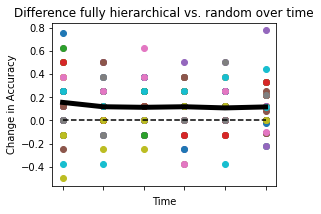

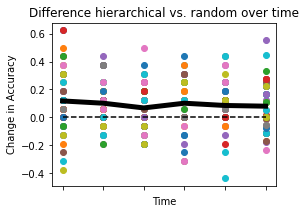

In [324]:
# print(mean_r_tt.shape) # subj_id, split_count, tt
type_names = ["2 Chunks","1 Chunk, 2 Random","4 Random"]

plt.rcParams['figure.figsize'] = [4, 3]

mean_r_tt_MeanSub = np.mean(mean_r_tt,0)
# print(mean_r_tt_MeanSub.shape)

## plot change in conditions over time
# mean_r_tt_MeanSub_diff = np.diff(mean_r_tt_MeanSub,axis=0)
# # print(mean_r_tt_MeanSub_diff)

# # plt.plot([1,2,3,4],mean_r_tt_MeanSub_diff[:,0],'bo')
# plt.plot(np.arange(1,n_split),mean_r_tt_MeanSub_diff[:,0],'b')
# plt.plot(np.arange(1,n_split),mean_r_tt_MeanSub_diff[:,1],color=[1.0, 0.5, 0.25])
# plt.plot(np.arange(1,n_split),mean_r_tt_MeanSub_diff[:,2],'g')
# plt.plot(np.arange(1,n_split),np.zeros(n_split-1),'--k')

# plt.xticks(np.arange(1,n_split), ["1 to 2","2 to 3","3 to 4","4 to 5","5 to 6"])
# plt.xlabel("Sessions")
# plt.ylabel("Change in Accuracy")
# plt.title("Change in Accuracy  across sessions")
# plt.legend(type_names)
# plt.show()

## plot diff between conditions over time
# print(mean_r_tt[0,:,0]-mean_r_tt[0,:,2])
Titles_id_mean = np.array(ids)
Titles_id_mean = np.append(Titles_id_mean,"mean")

diff_mean_r_tt = mean_r_tt[:,:,0]-mean_r_tt[:,:,2]

# plt.boxplot(diff_mean_r_tt)
plt.plot(np.transpose(diff_mean_r_tt,(1, 0)),'o')
plt.plot(np.arange(0,n_split),np.mean(diff_mean_r_tt,0),'k',linewidth=5)
plt.plot(np.arange(0,n_split),np.zeros(n_split),'--k')
# plt.plot(np.arange(0,n_split-2),np.mean(diff_mean_r_tt,0),'k',linewidth=5)
# plt.plot(np.arange(0,n_split-2),np.zeros(n_split-2),'--k')

# plt.xticks(np.arange(0,n_split), ["1/6","2/6","3/6","4/6","5/6","6/6"])
plt.xticks(np.arange(0,n_split), [])
plt.xlabel("Time")
plt.ylabel("Change in Accuracy")
plt.title("Difference fully hierarchical vs. random over time")
# plt.ylim(-1,1)
# plt.legend(Titles_id_mean)
plt.show()


## plot diff between conditions over time
# print(mean_r_tt[0,:,0]-mean_r_tt[0,:,2])
diff_mean21_r_tt = np.mean(mean_r_tt[:,:,0:2],2)-mean_r_tt[:,:,2]

plt.plot(np.transpose(diff_mean21_r_tt,(1, 0)),'o')
plt.plot(np.arange(0,n_split),np.mean(diff_mean21_r_tt,0),'k',linewidth=5)
plt.plot(np.arange(0,n_split),np.zeros(n_split),'--k')
# plt.plot(np.arange(0,n_split-2),np.mean(diff_mean21_r_tt,0),'k',linewidth=5)
# plt.plot(np.arange(0,n_split-2),np.zeros(n_split-2),'--k')

# plt.xticks(np.arange(0,n_split), ["1/6","2/6","3/6","4/6","5/6","6/6"])
plt.xticks(np.arange(0,n_split), [])
plt.xlabel("Time")
plt.ylabel("Change in Accuracy")
plt.title("Difference hierarchical vs. random over time")
# plt.ylim(-1,1)
# plt.legend(Titles_id_mean)
plt.show()

# print(diff_mean_r_tt)
# print(diff_mean21_r_tt)

## GLM: change in accuracy differences

In [325]:
# GLM for these differences:

# Fully hierarchical vs. random
data = np.transpose(diff_mean_r_tt,(1, 0))
# design matrix: linear effect of time, mean
dm = np.concatenate((np.array(np.arange(n_split),ndmin=2).T,
                      np.array(np.ones(n_split),ndmin=2).T),1)
cm = np.array([1,0],ndmin=2) # linear effect
# cm = np.array([0,1],ndmin=2) # mean effect
betas,var_betas,tstat_betas = ols_PS(data,
                                    dm,
                                    cm)
test = stats.ttest_1samp(betas[0], 0)
print("Fully hierarchical vs. random: " + 
      "t(" + str(np.size(betas,1)-1) + ")=" + str(test.statistic) +
      ", p=" + str(test.pvalue))

# Hierarchical vs. random
data = np.transpose(diff_mean21_r_tt,(1, 0))
# design matrix: linear effect of time, mean
dm = np.concatenate((np.array(np.arange(n_split),ndmin=2).T,
                      np.array(np.ones(n_split),ndmin=2).T),1)
cm = np.array([1,0],ndmin=2) # linear effect
# cm = np.array([0,1],ndmin=2) # mean effect
betas,var_betas,tstat_betas = ols_PS(data,
                                    dm,
                                    cm)
test = stats.ttest_1samp(betas[0], 0)
print("Hierarchical vs. random: " + 
      "t(" + str(np.size(betas,1)-1) + ")=" + str(test.statistic) +
      ", p=" + str(test.pvalue))

Fully hierarchical vs. random: t(49)=-1.0657590589786448, p=0.29175597155485666
Hierarchical vs. random: t(49)=-1.0973177078709018, p=0.2778658651763391


## Mean Accuracies

[[0.78       0.705      0.625     ]
 [0.8375     0.805      0.72      ]
 [0.8775     0.7875     0.765     ]
 [0.89       0.8575     0.7725    ]
 [0.8975     0.8525     0.79      ]
 [0.90827778 0.83666667 0.79244444]]


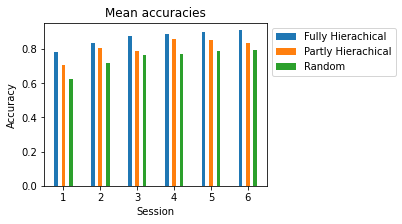

In [326]:
plt.rcParams['figure.figsize'] = [4, 3]

# print(mean_r_tt)
print(np.mean(mean_r_tt[:,:,:],0))

type_names = ["Fully Hierachical","Partly Hierachical","Random"]

for tt in trial_types:
  # plt.bar(X_axis_t+TrialT_axisBar[tt],np.mean(mean_r_tt[:,:,tt],0),0.1,label=["Trialtype " + str(tt)])
  plt.bar(X_axis_t+TrialT_axisBar[tt],np.mean(mean_r_tt[:,:,tt],0),0.1,label=type_names[tt])
  # print(np.mean(mean_r_tt[:,:,tt],0))
  # print(X_axis_t+TrialT_axisBar[tt])
  # plt.boxplot(mean_r_tt[:,:,tt],positions=X_axis_t+TrialT_axisBar[tt])
  # plt.boxplot(mean_r_tt[:,:,tt])
# print(np.mean(mean_r,0))
# plt.bar(X_axis_t+TrialT_axisBar[tt],np.mean(mean_r,0),0.1,label=["Trialtype " + str(tt)])

plt.xticks(X_axis_t, X)
# plt.xlabel("Time in Task")
plt.xlabel("Session")
plt.ylabel("Accuracy")
plt.title("Mean accuracies")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

## RTs

In [327]:
# ids = [225,227, 262,265]
# ids = [530,531,532,533,535]
# ids = [530,531,532,533,535,548]

# n_trials    = 180
# n_trials_tt = 60
# n_split     = 6

trial_types = list(range(3))
trial_type_accuracy = {}

# split_by = 5
# sess_split_t = np.arange(0,210,210/5).astype(int)
# sess_split_tt = np.arange(0,70,70/5).astype(int)
sess_split_t = np.arange(0,n_trials,n_trials/n_split).astype(int)
sess_split_tt = np.arange(0,n_trials_tt,n_trials_tt/n_split).astype(int)

mean_rt = np.zeros((np.size(ids,0),n_split))
mean_rt_tt = np.zeros((np.size(ids,0),n_split,3))

# step_size_t = int(210/split_by)
# step_size_tt = int(70/split_by)
step_size_t = int(n_trials/n_split)
step_size_tt = int(n_trials_tt/n_split)

subj_id = 0

subj_axisBar = np.linspace(-0.3, 0.3, int(len(ids)))

TrialT_axisBar = np.linspace(-0.2, 0.2, 3)

X_axis_t = np.arange(0,len(sess_split_tt))

# X = ["1/5","2/5","3/5","4/5","5/5"]
X = ["1/6","2/6","3/6","4/6","5/6","6/6"]

for session_id in ids:
    print("\nSession ", session_id)
    trials = trial_df[trial_df['session_id'] == session_id]
    reaction_time = []

    for trial_id in trials["trial_id"]:
        actions = action_df[action_df["trial_id"] == trial_id]
        reaction_time.append(actions["reaction_time"].sum())

    # print(np.shape(reaction_time))
    
    # print("Mean reaction time: ", round(np.mean(reaction_time),2), "Seconds")
    # plt.plot(range(1,len(trials)+1), reaction_time)
    # plt.show()

    # for tt in trial_types:
    #     # silhouettes_tt = silhouette_df[silhouette_df["trial_type"] == tt]
    #     silhouettes_tt = silhouette_df[trialtypes_old == tt]
    #     trials_tt = trials[trials["silhouette_id"].isin(silhouettes_tt["silhouette_id"])]
    #     accuracy = trials_tt["reward"].sum()/len(trials_tt)
    #     print("Trial Type: ", tt, "Accuracy: ", round(accuracy*100,2), "%")

    split_count = 0
    for idx_split in sess_split_t:
      if idx_split == sess_split_t[-1]:
        mean_rt[subj_id,split_count] = np.mean(reaction_time[idx_split:])
      else:
        mean_rt[subj_id,split_count] = np.mean(reaction_time[idx_split:idx_split+step_size_t])
      split_count += 1

    if plot_indiv:
      plt.bar(X_axis_t+subj_axisBar[subj_id],mean_rt[subj_id,:],0.1,label=["subj " + str(ids[subj_id])])

    subj_id +=1

if plot_indiv:
  plt.xticks(X_axis_t, X)
  plt.xlabel("Time in Task")
  plt.ylabel("RT")
  plt.title("RT across task")
  plt.legend()
  plt.show()


Session  685

Session  686

Session  687

Session  689

Session  690

Session  691

Session  692

Session  694

Session  695

Session  696

Session  727

Session  728

Session  730

Session  732

Session  733

Session  737

Session  738

Session  741

Session  742

Session  743

Session  744

Session  748

Session  749

Session  752

Session  753

Session  756

Session  758

Session  759

Session  762

Session  763

Session  764

Session  769

Session  770

Session  771

Session  772

Session  774

Session  775

Session  776

Session  777

Session  778

Session  785

Session  788

Session  789

Session  790

Session  791

Session  793

Session  795

Session  796

Session  797

Session  798


## Individual RTs

In [328]:
# ids = [225,227, 262,265]
# ids = [530,531,532,533,535]
# ids = [530,531,532,533,535,548]

# n_trials    = 180
# n_trials_tt = 60
# n_split     = 6

trial_types = list(range(3))
trial_type_accuracy = {}

type_names = ["2 Chunks","1 Chunk, 2 Random","4 Random"]

# split_by = 5
# sess_split_t = np.arange(0,210,210/5).astype(int)
# sess_split_tt = np.arange(0,70,70/5).astype(int)
sess_split_t = np.arange(0,n_trials,n_trials/n_split).astype(int)
sess_split_tt = np.arange(0,n_trials_tt,n_trials_tt/n_split).astype(int)

mean_rt = np.zeros((np.size(ids,0),n_split))
mean_rt_tt = np.zeros((np.size(ids,0),n_split,3))

# step_size_t = int(210/split_by)
# step_size_tt = int(70/split_by)
step_size_t = int(n_trials/n_split)
step_size_tt = int(n_trials_tt/n_split)

subj_id = 0

subj_axisBar = np.linspace(-0.3, 0.3, int(len(ids)))

TrialT_axisBar = np.linspace(-0.2, 0.2, 3)

X_axis_t = np.arange(0,len(sess_split_tt))

# X = ["1/5","2/5","3/5","4/5","5/5"]
X = ["1/6","2/6","3/6","4/6","5/6","6/6"]

for session_id in ids:

    trial_type_sub = []
    for idx in trial_df[trial_df['session_id'] == session_id]["trial_type"]:
      trial_type_sub.append(int(idx))

    trial_type_sub = np.array(trial_type_sub)

    print("\nSession ", session_id)
    trials = trial_df[trial_df['session_id'] == session_id]
    reaction_time = []

    for trial_id in trials["trial_id"]:
        actions = action_df[action_df["trial_id"] == trial_id]
        reaction_time.append(actions["reaction_time"].sum())

    reaction_time = np.array(reaction_time)

    # reward_tt = reward[trial_type_sub==tt]

    for tt in trial_types:
      reaction_time_tt = reaction_time[trial_type_sub==tt]
      # if session_id == 225:
      #   reaction_time_tt = reaction_time[trialtypes_old[:-1] == tt]        
      # else:
      #   reaction_time_tt = reaction_time[trialtypes_old == tt]

      split_count = 0
      for idx_split in sess_split_tt:
        # mean_rt[subj_id,split_count] = np.mean(reaction_time_tt[idx_split:idx_split+step_size_tt])
        # mean_rt_tt[subj_id,split_count,tt] = np.mean(reaction_time_tt[idx_split:idx_split+step_size_tt])
        if idx_split == sess_split_tt[-1]:
          mean_rt[subj_id,split_count] = np.mean(reaction_time_tt[idx_split:])
          mean_rt_tt[subj_id,split_count,tt] = np.mean(reaction_time_tt[idx_split:])
        else:
          mean_rt[subj_id,split_count] = np.mean(reaction_time_tt[idx_split:idx_split+step_size_tt])
          mean_rt_tt[subj_id,split_count,tt] = np.mean(reaction_time_tt[idx_split:idx_split+step_size_tt])
        split_count += 1

      # print(mean_rt_tt[subj_id,:])
      # plt.bar(X_axis_t+TrialT_axisBar[tt],mean_rt[subj_id,:],0.1,label=["Trialtype " + str(tt)])
      if plot_indiv:
        plt.bar(X_axis_t+TrialT_axisBar[tt],mean_rt[subj_id,:],0.1,label=type_names[tt])

    if plot_indiv:
      plt.xticks(X_axis_t, X)
      plt.xlabel("Time in Task")
      plt.ylabel("RT (sec)")
      plt.title("RT across task subject " + str(session_id))
      plt.legend()
      plt.show()

    subj_id +=1


Session  685

Session  686

Session  687

Session  689

Session  690

Session  691

Session  692

Session  694

Session  695

Session  696

Session  727

Session  728

Session  730

Session  732

Session  733

Session  737

Session  738

Session  741

Session  742

Session  743

Session  744

Session  748

Session  749

Session  752

Session  753

Session  756

Session  758

Session  759

Session  762

Session  763

Session  764

Session  769

Session  770

Session  771

Session  772

Session  774

Session  775

Session  776

Session  777

Session  778

Session  785

Session  788

Session  789

Session  790

Session  791

Session  793

Session  795

Session  796

Session  797

Session  798


## GLM: change in RT over time

In [329]:
for idx_tt in np.arange(3):

  data = mean_rt_tt[:,:,idx_tt].T
  # design matrix: linear effect of time, mean
  dm = np.concatenate((np.array(np.arange(n_split),ndmin=2).T,
                       np.array(np.ones(n_split),ndmin=2).T),1)
  cm = np.array([1,0],ndmin=2)
  betas,var_betas,tstat_betas = ols_PS(data,
                                      dm,
                                      cm)
  test = stats.ttest_1samp(betas[0], 0)
  print("Trialtype: " + str(idx_tt) + 
        ", t(" + str(np.size(betas,1)-1) + ")=" + str(test.statistic) +
        ", p=" + str(test.pvalue))

Trialtype: 0, t(49)=-9.113019831483415, p=4.0029515648662395e-12
Trialtype: 1, t(49)=-3.829985819479712, p=0.00036479066039879265
Trialtype: 2, t(49)=-3.3357509821623594, p=0.0016283313199222367


## Change in individual differences RT

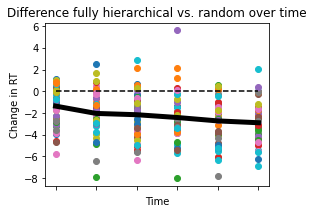

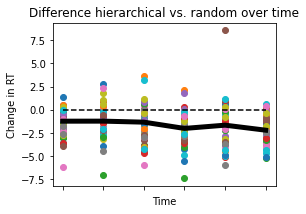

In [330]:
# print(mean_r_tt.shape) # subj_id, split_count, tt
type_names = ["2 Chunks","1 Chunk, 2 Random","4 Random"]

plt.rcParams['figure.figsize'] = [4, 3]

mean_rt_tt_MeanSub = np.mean(mean_rt_tt,0)
# print(mean_rt_tt_MeanSub)

# mean_rt_tt_MeanSub_diff = np.diff(mean_rt_tt_MeanSub,axis=0)
# # print(mean_rt_tt_MeanSub_diff)

# # plt.plot([1,2,3,4],mean_r_tt_MeanSub_diff[:,0],'bo')
# plt.plot(np.arange(1,n_split),mean_rt_tt_MeanSub_diff[:,0],'b')
# # plt.plot([1,2,3,4],mean_r_tt_MeanSub_diff[:,1],color='orange')
# plt.plot(np.arange(1,n_split),mean_rt_tt_MeanSub_diff[:,1],color=[1.0, 0.5, 0.25])
# plt.plot(np.arange(1,n_split),mean_rt_tt_MeanSub_diff[:,2],'g')
# plt.plot(np.arange(1,n_split),np.zeros(n_split-1),'--k')

# plt.xticks(np.arange(1,n_split), ["1 to 2","2 to 3","3 to 4","4 to 5","5 to 6"])
# plt.xlabel("Sessions")
# plt.ylabel("Change in RT")
# plt.title("Change in RT across sessions")
# plt.legend(type_names)
# plt.show()

## plot diff between conditions over time
# print(mean_r_tt[0,:,0]-mean_r_tt[0,:,2])
Titles_id_mean = np.array(ids)
Titles_id_mean = np.append(Titles_id_mean,"mean")

diff_mean_rt_tt = mean_rt_tt[:,:,0]-mean_rt_tt[:,:,2]
# print(diff_mean_rt_tt)

# plt.boxplot(diff_mean_rt_tt)
plt.plot(np.transpose(diff_mean_rt_tt,(1, 0)),'o')
plt.plot(np.arange(0,n_split),np.mean(diff_mean_rt_tt,0),'k',linewidth=5)
plt.plot(np.arange(0,n_split),np.zeros(n_split),'--k')

# plt.xticks(np.arange(0,n_split), ["1/6","2/6","3/6","4/6","5/6","6/6"])
plt.xticks(np.arange(0,n_split), [])
plt.xlabel("Time")
plt.ylabel("Change in RT")
plt.title("Difference fully hierarchical vs. random over time")
# plt.legend(Titles_id_mean)
plt.show()

## plot diff between conditions over time
# print(mean_r_tt[0,:,0]-mean_r_tt[0,:,2])
diff_mean21_rt_tt = np.mean(mean_rt_tt[:,:,0:2],2)-mean_rt_tt[:,:,2]

plt.plot(np.transpose(diff_mean21_rt_tt,(1, 0)),'o')
plt.plot(np.arange(0,n_split),np.mean(diff_mean21_rt_tt,0),'k',linewidth=5)
plt.plot(np.arange(0,n_split),np.zeros(n_split),'--k')

# plt.xticks(np.arange(0,n_split), ["1/6","2/6","3/6","4/6","5/6","6/6"])
plt.xticks(np.arange(0,n_split), [])
plt.xlabel("Time")
plt.ylabel("Change in RT")
# plt.title("Difference 2 Chunk or 1 Chunk vs. Random  across sessions")
plt.title("Difference hierarchical vs. random over time")
# plt.legend(Titles_id_mean)
plt.show()

## GLM: change in RT differences

In [331]:
# GLM for these differences:

# Fully hierarchical vs. random
data = np.transpose(diff_mean_rt_tt,(1, 0))
# design matrix: linear effect of time, mean
dm = np.concatenate((np.array(np.arange(n_split),ndmin=2).T,
                      np.array(np.ones(n_split),ndmin=2).T),1)
cm = np.array([1,0],ndmin=2) # linear effect
# cm = np.array([0,1],ndmin=2) # mean effect
betas,var_betas,tstat_betas = ols_PS(data,
                                    dm,
                                    cm)
test = stats.ttest_1samp(betas[0], 0)
print("Fully hierarchical vs. random: " + 
      "t(" + str(np.size(betas,1)-1) + ")=" + str(test.statistic) +
      ", p=" + str(test.pvalue))

# Hierarchical vs. random
data = np.transpose(diff_mean21_rt_tt,(1, 0))
# design matrix: linear effect of time, mean
dm = np.concatenate((np.array(np.arange(n_split),ndmin=2).T,
                      np.array(np.ones(n_split),ndmin=2).T),1)
cm = np.array([1,0],ndmin=2) # linear effect
# cm = np.array([0,1],ndmin=2) # mean effect
betas,var_betas,tstat_betas = ols_PS(data,
                                    dm,
                                    cm)
test = stats.ttest_1samp(betas[0], 0)
print("Hierarchical vs. random: " + 
      "t(" + str(np.size(betas,1)-1) + ")=" + str(test.statistic) +
      ", p=" + str(test.pvalue))

Fully hierarchical vs. random: t(49)=-4.901020514223535, p=1.0853861694907607e-05
Hierarchical vs. random: t(49)=-4.095085975772138, p=0.00015754450984535034


## Mean RTs

[[ 9.59601     9.8705725  10.95281   ]
 [ 8.2945475   9.9291325  10.3273225 ]
 [ 7.5854625   9.2391975   9.7374025 ]
 [ 7.48598     8.30294     9.895185  ]
 [ 6.9922325   9.1393775   9.715425  ]
 [ 6.81876089  8.22187444  9.710531  ]]


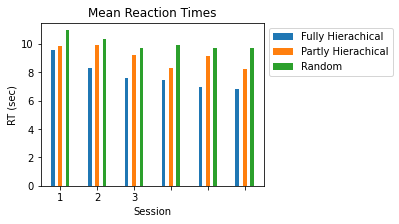

In [332]:
# print(mean_r_tt)
plt.rcParams['figure.figsize'] = [4, 3]

print(np.mean(mean_rt_tt[:,:,:],0))

# type_names = ["2 Chunks","1 Chunk, 2 Random","4 Random"]
type_names = ["Fully Hierachical","Partly Hierachical","Random"]

for tt in trial_types:
  # plt.bar(X_axis_t+TrialT_axisBar[tt],np.mean(mean_r_tt[:,:,tt],0),0.1,label=["Trialtype " + str(tt)])
  plt.bar(X_axis_t+TrialT_axisBar[tt],np.mean(mean_rt_tt[:,:,tt],0),0.1,label=type_names[tt])
# print(np.mean(mean_r,0))
# plt.bar(X_axis_t+TrialT_axisBar[tt],np.mean(mean_r,0),0.1,label=["Trialtype " + str(tt)])

plt.xticks(X_axis_t, ["1","2","3"])
# plt.xlabel("Time in Task")
plt.xlabel("Session")
plt.ylabel("RT (sec)")
plt.title("Mean Reaction Times")
# plt.legend(loc='best')
# plt.legend(loc='upper center')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

## Individual BB selection pattern

In [333]:
# action_df = pd.DataFrame(pd_data, columns=['action_id', 'trial_id', 'building_block', 'reaction_time', 'selected'])
# print(action_df.head())

plt.rcParams['figure.figsize'] = [15, 3]

# stim set 0 chunks: [0,1], [3,5] 
# stim set 1 chunks: [4,5], [3,2]

# ids = [225,227,262,265] # this is pilot
# ids = [530,531,532,533,535] # stim set 0, prolific only
# ids = [530,531,532,533,535,548] # stim set 0, all subs
# ids = [554,555,556,557,558] # stim set 0, prolific only

# rows = len(ids)
rows = 1
cols = 4

selection_transitions           = np.zeros((len(ids),6,6,3))
selection_transitions_normalise = np.multiply(np.ones((len(ids),6,6,3)),0.5)
# print(selection_transitions)

subj_count = 0

for session_id in ids:
# for session_id in [ids[0]]:
    # print("\nSubject ", session_id)
    trials = trial_df[trial_df['session_id'] == session_id]
    first_BB  = []
    second_BB = []
    third_BB  = []
    fourth_BB = []

    # fig = plt.figure() 

    # fig_count = 1; 

    # print(trials["trial_id"])

    all_trials = trials["trial_id"].to_numpy()
    # print(all_trials)

    # print(len(trials["trial_id"]))

    reward = trials["reward"].to_numpy()

    trial_type_sub = []
    for idx in trial_df[trial_df['session_id'] == session_id]["trial_type"]:
      trial_type_sub.append(int(idx))

    trial_type_sub = np.array(trial_type_sub)

    trial_count = 0

    for trial_id in trials["trial_id"]:
    # for trial_id in [5797]:
    # for trial_id in all_trials[:121]: # for now, only use first two sessions without randomisation
    # for trial_id in all_trials[121:]: # last session with randomisation
        actions = action_df[action_df["trial_id"] == trial_id]
        # print(actions)
        # print(np.all(actions["selected"]==True))
        # if np.all(actions["selected"]==True) and len(actions["selected"])==4:
        if np.all(actions["selected"]==True) and len(actions["selected"])==4 and reward[trial_count]==1:
          
          # BBs = actions["building_block"]
          # first_BB.append(actions["building_block"])

          BBs_all = actions["building_block"].to_numpy()

          first_BB.append(BBs_all[0])
          second_BB.append(BBs_all[1])
          third_BB.append(BBs_all[2])
          fourth_BB.append(BBs_all[3])

          selection_transitions[subj_count,BBs_all[0],BBs_all[1],trial_type_sub[trial_count]] += 1
          selection_transitions[subj_count,BBs_all[1],BBs_all[2],trial_type_sub[trial_count]] += 1
          selection_transitions[subj_count,BBs_all[2],BBs_all[3],trial_type_sub[trial_count]] += 1

          # create matrix with all possible orders for normalisation
          for idx_row in BBs_all:
            for idx_col in BBs_all:
              if selection_transitions_normalise[subj_count,idx_row,idx_col,trial_type_sub[trial_count]]==0.5:
                selection_transitions_normalise[subj_count,idx_row,idx_col,trial_type_sub[trial_count]] = 1
              else:
                selection_transitions_normalise[subj_count,idx_row,idx_col,trial_type_sub[trial_count]] += 1


          # selection_transitions_normalise[subj_count,BBs_all[0],BBs_all[1],trial_type_sub[trial_count]] += 1
          # selection_transitions_normalise[subj_count,BBs_all[1],BBs_all[0],trial_type_sub[trial_count]] += 1

          # selection_transitions_normalise[subj_count,BBs_all[1],BBs_all[2],trial_type_sub[trial_count]] += 1
          # selection_transitions_normalise[subj_count,BBs_all[2],BBs_all[1],trial_type_sub[trial_count]] += 1

          # selection_transitions_normalise[subj_count,BBs_all[2],BBs_all[3],trial_type_sub[trial_count]] += 1
          # selection_transitions_normalise[subj_count,BBs_all[3],BBs_all[2],trial_type_sub[trial_count]] += 1

        trial_count +=1

    # selection_transitions[subj_count,:,:,0] = np.divide(selection_transitions[subj_count,:,:,0],50)
    # selection_transitions[subj_count,:,:,1] = np.divide(selection_transitions[subj_count,:,:,1],50)
    # selection_transitions[subj_count,:,:,2] = np.divide(selection_transitions[subj_count,:,:,2],50)

    # print(selection_transitions[subj_count,:,:,0])

    selection_transitions[subj_count,:,:,0] = np.divide(selection_transitions[subj_count,:,:,0],selection_transitions_normalise[subj_count,:,:,0])
    selection_transitions[subj_count,:,:,1] = np.divide(selection_transitions[subj_count,:,:,1],selection_transitions_normalise[subj_count,:,:,1])
    selection_transitions[subj_count,:,:,2] = np.divide(selection_transitions[subj_count,:,:,2],selection_transitions_normalise[subj_count,:,:,2])

    # print(selection_transitions[subj_count,:,:,0])

    # print(selection_transitions_normalise[subj_count,:,:,0])
    # print(selection_transitions_normalise[subj_count,:,:,1])
    # print(selection_transitions_normalise[subj_count,:,:,2])
    
    # print(first_BB)
    # print(len(first_BB))

    if plot_indiv:
      fig = plt.figure() 

      fig_count = 1; 

      fig.add_subplot(rows, cols, fig_count)
      plt.hist(first_BB, bins=6, range=(-1,6),color="dodgerblue")
      plt.xticks(np.arange(0,6), np.arange(0,6))
      plt.title('Frequency First Building Blocks')    
      fig_count += 1;
      fig.add_subplot(rows, cols, fig_count)
      plt.hist(second_BB, bins=6, range=(-1,6),color="darkorange")
      plt.xticks(np.arange(0,6), np.arange(0,6))
      plt.title('Frequency Second Building Blocks')    
      fig_count += 1;
      fig.add_subplot(rows, cols, fig_count)
      plt.hist(third_BB, bins=6, range=(-1,6),color="darkolivegreen")
      plt.xticks(np.arange(0,6), np.arange(0,6))
      plt.title('Frequency Third Building Blocks')    
      fig_count += 1;
      fig.add_subplot(rows, cols, fig_count)
      plt.hist(fourth_BB, bins=6, range=(-1,6),color="blueviolet")
      plt.xticks(np.arange(0,6), np.arange(0,6))
      plt.title('Frequency Fourth Building Blocks')    
      fig_count += 1;

      plt.show()


      fig = plt.figure() 

      fig_count = 1; 

      fig.add_subplot(rows, cols, fig_count)
      plt.imshow(selection_transitions[subj_count,:,:,0])
      plt.title('Fully hierarchical') 
      plt.colorbar()
      fig_count += 1;
      fig.add_subplot(rows, cols, fig_count)
      plt.imshow(selection_transitions[subj_count,:,:,1])
      plt.title('Partly hierarchical')
      plt.colorbar()
      fig_count += 1;
      fig.add_subplot(rows, cols, fig_count)
      plt.imshow(selection_transitions[subj_count,:,:,2])
      plt.title('Random')
      plt.colorbar()
      fig_count += 1;
      plt.show()

    subj_count += 1

In [334]:
print(selection_transitions[0,:,:,0])

[[0.         0.48837209 0.         0.         0.1627907  0.13953488]
 [0.51162791 0.         0.         0.         0.27906977 0.06976744]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.04651163 0.         0.         0.         0.         0.76744186]
 [0.11627907 0.20930233 0.         0.         0.20930233 0.        ]]


## Mean BB selection pattern

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[31, 32, 33, 34, 35, 36, 37, 38, 39]
[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


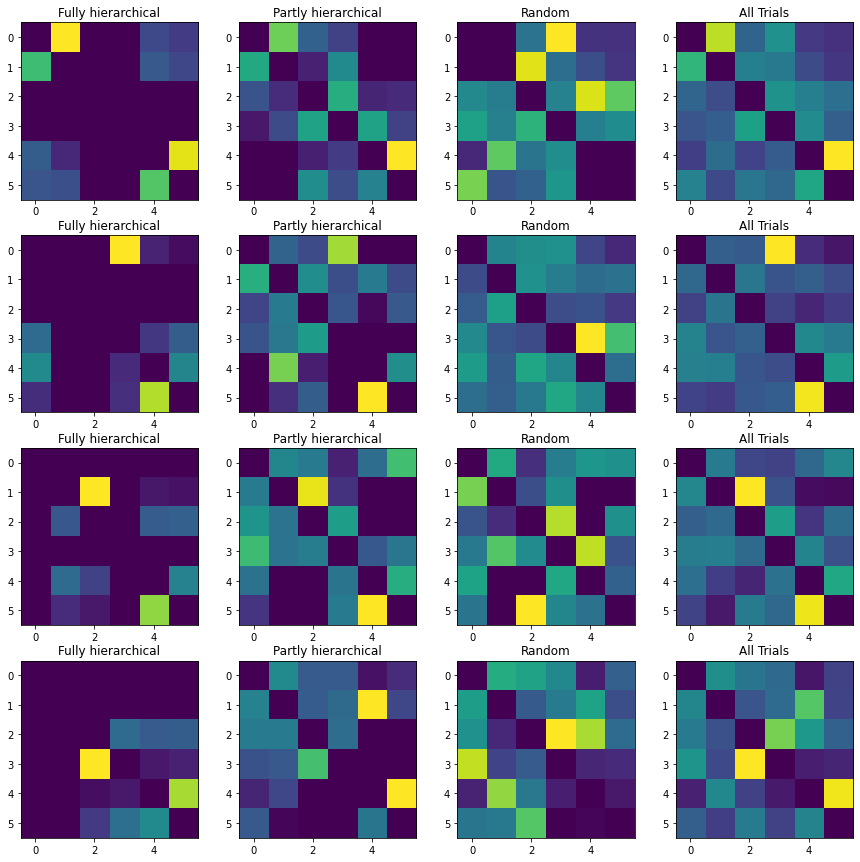

In [335]:
plt.rcParams['figure.figsize'] = [15, 15]


ids_4 = [685,686,687,689,690,691,692,694,695,696] # stim set 4, prolific only
ids_5_1 = [727,728,730,732,733,737,738,741,742,743,744] # stim set 5, prolific only
ids_5_2 = [748,749,752,753,756,758,759,762,763,764] # stim set 5, prolific only
ids_6 = [769,770,771,772,774,775,776,777,778] # stim set 6, prolific only
ids_7 = [785,788,789,790,791,793,795,796,797,798] # stim set 6, prolific only

idx_4 = []
[idx_4.append(np.where(x==ids)[0][0]) for x in ids_4]
idx_5 = []
[idx_5.append(np.where(x==ids)[0][0]) for x in np.concatenate((ids_5_1,ids_5_2))]
idx_6 = []
[idx_6.append(np.where(x==ids)[0][0]) for x in ids_6]
idx_7 = []
[idx_7.append(np.where(x==ids)[0][0]) for x in ids_7]

idx_s = [idx_4,idx_5,idx_6,idx_7]

rows = 4
cols = 4

fig = plt.figure() 

fig_count = 1; 

n_subs = np.size(selection_transitions,0)

for idx_subs in idx_s:

  print(idx_subs)

  fig.add_subplot(rows, cols, fig_count)
  # plt.imshow(np.sum(selection_transitions[:,:,:,0],0))
  # plt.imshow(np.divide(np.sum(selection_transitions[:,:,:,0],0),n_subs))
  plt.imshow(np.divide(np.sum(selection_transitions[idx_subs,:,:,0],0),len(idx_subs)))
  plt.title('Fully hierarchical') 
  # plt.colorbar()
  fig_count += 1;
  
  fig.add_subplot(rows, cols, fig_count)
  # plt.imshow(np.divide(np.sum(selection_transitions[:,:,:,1],0),n_subs))
  plt.imshow(np.divide(np.sum(selection_transitions[idx_subs,:,:,1],0),len(idx_subs)))
  plt.title('Partly hierarchical')
  # plt.colorbar()
  fig_count += 1;

  fig.add_subplot(rows, cols, fig_count)
  # plt.imshow(np.divide(np.sum(selection_transitions[:,:,:,2],0),n_subs))
  plt.imshow(np.divide(np.sum(selection_transitions[idx_subs,:,:,2],0),len(idx_subs)))
  plt.title('Random')
  # plt.colorbar()
  fig_count += 1;

  fig.add_subplot(rows, cols, fig_count)
  # plt.imshow(np.divide(np.sum(np.sum(selection_transitions[:,:,:,:],0),2),n_subs*3))
  plt.imshow(np.divide(np.sum(np.sum(selection_transitions[idx_subs,:,:,:],0),2),len(idx_subs)*3))
  plt.title('All Trials')
  # plt.colorbar()
  fig_count += 1;

plt.show()

In [336]:
# # plt.rcParams['figure.figsize'] = [14, 7]
# plt.rcParams['figure.figsize'] = [15, 3]

# # ids = [225,227,262,265] # this is pilot
# # ids = [530,531,532,533,535] # stim set 0, prolific only
# # ids = [530,531,532,533,535,548] # stim set 0, all subs
# # ids = [554,555,556,557,558] # stim set 0, prolific only

# # stim set 0 chunks: [0,1], [3,5] 
# # stim set 1 chunks: [4,5], [3,2]
# chunk_0 = [0,1]
# chunk_1 = [3,5]

# # chunk_0 = [4,5]
# # chunk_1 = [3,2]

# for session_id in ids:
#     # print("\nSubject ", session_id)
#     trials = trial_df[trial_df['session_id'] == session_id]

#     fig = plt.figure() 

#     fig_count = 1; 

#     # print(trials["trial_id"])

#     all_trials = trials["trial_id"].to_numpy()
#     # print(all_trials)

#     prop_chunk0 = []
#     prop_chunk1 = []

#     # for trial_id in trials["trial_id"]:
#     for trial_id in all_trials:
#     # for trial_id in all_trials[:60]: # for now, only use first two sessions without randomisation
#     # for trial_id in all_trials[60:120]: # for now, only use first two sessions without randomisation
#     # for trial_id in all_trials[120:]: # for now, only use first two sessions without randomisation
#     # for trial_id in all_trials[:121]: # for now, only use first two sessions without randomisation
#     # for trial_id in all_trials[121:]: # last session with randomisation
#         actions = action_df[action_df["trial_id"] == trial_id]
#         # print(actions)
#         # print(np.all(actions["selected"]==True))
#         if np.all(actions["selected"]==True) and len(actions["selected"])==4:
          
#           # BBs = actions["building_block"]
#           # first_BB.append(actions["building_block"])

#           BBs_all = actions["building_block"].to_numpy()

#           if np.all(np.isin(chunk_0,BBs_all)):
#             if np.abs(np.diff(np.where(np.isin(BBs_all,chunk_0))[0]))==1:
#               prop_chunk0.append(1)
#             else:
#               prop_chunk0.append(0)

#           if np.all(np.isin(chunk_1,BBs_all)):
#             if np.abs(np.diff(np.where(np.isin(BBs_all,chunk_1))[0]))==1:
#               prop_chunk1.append(1)
#             else:
#               prop_chunk1.append(0)

#     fig.add_subplot(rows, cols, fig_count)
#     # plt.hist(prop_chunk0, bins=2, range=(-1,2),density=True,color="dodgerblue")
#     plt.bar([0,1], [1-np.mean(prop_chunk0),np.mean(prop_chunk0)],color="peru")
#     plt.xticks(np.arange(0,2), np.arange(0,2))
#     plt.title('Frequency Chunk 0 Selection') 
#     plt.ylim(0, 1)   
#     fig_count += 1;
#     fig.add_subplot(rows, cols, fig_count)
#     # plt.hist(prop_chunk1, bins=2, range=(-1,2),density=True,color="darkorange")
#     plt.bar([0,1], [1-np.mean(prop_chunk1),np.mean(prop_chunk1)],color="khaki")
#     plt.xticks(np.arange(0,2), np.arange(0,2))
#     plt.title('Frequency Chunk 1 Selection')  
#     plt.ylim(0, 1)  
#     fig_count += 1;

#     plt.show()  

# # print(np.mean(prop_chunk0))
# # print(np.mean(prop_chunk1))

## Debriefing

In [337]:
# r = requests.get(API_URL+"/debriefing")
# print("Status:", r.status_code)
# pd_data = []
# debr_sil = json.loads(r.text)

# print(debr_sil)

# for d in debr_sil:
#   print(d["left"])
#   record = [d["debriefing_id"]] 
#   pd_data.append(record)
    
# # print("Found", len(pd_data), "debriefing_actions")
    
# # debr_action_df = pd.DataFrame(pd_data, columns=["debriefing_action_id","session","debriefing_id","choice","reaction_time","left_type","right_type"])
# # # debr_action_df.head()
# # debr_action_df.tail()


In [338]:
## Debriefing tasks
r = requests.get(API_URL+"/debriefing_action")
print("Status:", r.status_code)
pd_data = []
debr_actions = json.loads(r.text)

print(debr_actions)

for d in debr_actions:
    record = [d["debriefing_action_id"], d["session"], d["debriefing_id"],d["choice"], d["reaction_time"], d["left_type"], d["right_type"]] 
    pd_data.append(record)
    
print("Found", len(pd_data), "debriefing_actions")
    
debr_action_df = pd.DataFrame(pd_data, columns=["debriefing_action_id","session","debriefing_id","choice","reaction_time","left_type","right_type"])
# debr_action_df.head()
debr_action_df.tail()

Status: 200
[{'debriefing_action_id': 1, 'session': 175, 'debriefing_id': '0', 'choice': 'right', 'reaction_time': 19.264, 'experiment_part': None, 'left_str': None, 'right_str': None, 'left_type': None, 'right_type': None}, {'debriefing_action_id': 2, 'session': 175, 'debriefing_id': '1', 'choice': 'left', 'reaction_time': 0.843, 'experiment_part': None, 'left_str': None, 'right_str': None, 'left_type': None, 'right_type': None}, {'debriefing_action_id': 3, 'session': 175, 'debriefing_id': '2', 'choice': 'right', 'reaction_time': 0.792, 'experiment_part': None, 'left_str': None, 'right_str': None, 'left_type': None, 'right_type': None}, {'debriefing_action_id': 4, 'session': 175, 'debriefing_id': '3', 'choice': 'right', 'reaction_time': 0.445, 'experiment_part': None, 'left_str': None, 'right_str': None, 'left_type': None, 'right_type': None}, {'debriefing_action_id': 5, 'session': 175, 'debriefing_id': '4', 'choice': 'left', 'reaction_time': 0.481, 'experiment_part': None, 'left_str'

debriefing_action_id  session  ... left_type right_type
6560                  6561      796  ...       3.0        4.0
6561                  6562      796  ...       4.0        4.0
6562                  6563      796  ...       4.0        4.0
6563                  6564      796  ...       4.0        4.0
6564                  6565      796  ...       4.0        4.0

[5 rows x 7 columns]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:224: RuntimeWarning: invalid value encountered in double_scalars


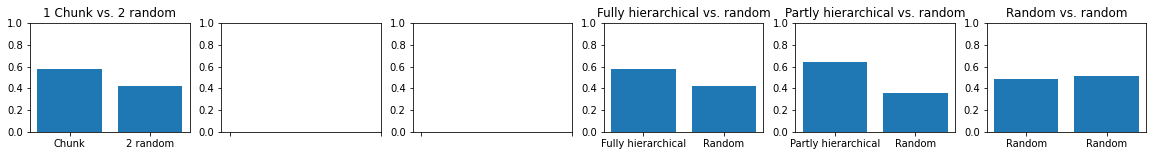

In [339]:
from numpy import genfromtxt
# debrief_trialtype = genfromtxt('/content/drive/My Drive/Colab Notebooks/Tangram/debrief_trial_StimSet0.csv', delimiter=',')
# debrief_trialtype = genfromtxt('/content/drive/My Drive/Colab Notebooks/Tangram/debrief_trial_StimSet1.csv', delimiter=',')
# debrief_trialtype = debrief_trialtype[1:,:]

plt.rcParams['figure.figsize'] = [20, 2]

# Eventually, this should be held out stims. For now, let's just do 30 trials where
# [5 trials] debrief_type = 0 <=> single chunk                             vs. 2 random primitive blocks
# [5 trials] debrief_type = 1 <=> 2 random primitive blocks                vs. 2 random primitive blocks
# [5 trials] debrief_type = 2 <=> 2 chunk silhouette                       vs. 1 chunk + 2 random primitives silhouette
# [5 trials] debrief_type = 3 <=> 2 chunk silhouette                       vs. 4 random primitive blocks
# [5 trials] debrief_type = 4 <=> 1 chunk + 2 random primitives silhouette vs. 4 random primitive blocks
# [5 trials] debrief_type = 5 <=> 4 random primitive blocks                vs. 4 random primitive blocks

# Stim types
# [0] single chunk
# [1] 2 random primitive blocks
# [2] 2 chunk silhouette
# [3] 1 chunk + 2 random primitives silhouette
# [4] 4 random primitive blocks

# ids = [225,227,262,265] # this is pilot
# ids = [530,531,532,533,535] # stim set 0, prolific only
# ids = [530]
# ids = [530,531,532,533,535,548] # stim set 0, all subs
# ids = [554,555,556,557,558] # stim set 0, prolific only
# ids = [579,582,583,584,585] # stim set 0, prolific only

# stim set 0 chunks: [0,1], [3,5] 
# stim set 1 chunks: [4,5], [3,2]
# chunk_0 = [0,1]
# chunk_1 = [3,5]

debrief_chosen          = np.zeros((6,2))
debrief_chosen_sub      = np.zeros((len(ids),6,2))
debrief_chosen_sess_sub = np.zeros((3,len(ids),6,2))
# print(debrief_chosen)
# print(np.sort([3,2]))

rows = 1
cols = 6

Titles_debrief = ["1 Chunk vs. 2 random", "", "",
                  "Fully hierarchical vs. random", "Partly hierarchical vs. random", "Random vs. random"]

sub_count = 0

x_ax = [["Chunk","2 random"],["",""],["",""],
        ["Fully hierarchical","Random"],["Partly hierarchical","Random"],["Random","Random"]]

for session_id in ids:
# for session_id in [579]:
    # print("\nSubject ", session_id)
    trials = debr_action_df[debr_action_df['session'] == session_id]
    # print(trials)

    choice_debrief = []

    left_trials  = trials["left_type"].to_numpy()
    right_trials = trials["right_type"].to_numpy()

    left_trials  = left_trials.astype(int)
    right_trials = right_trials.astype(int)

    choice_MatLeft  = np.zeros((int(np.max(left_trials)+1),int(np.max(right_trials)+1)))
    choice_MatRight = np.zeros((int(np.max(left_trials)+1),int(np.max(right_trials)+1)))

    choice_MatLeft_sess  = np.zeros((3,int(np.max(left_trials)+1),int(np.max(right_trials)+1)))
    choice_MatRight_sess = np.zeros((3,int(np.max(left_trials)+1),int(np.max(right_trials)+1)))

    # print(choice_MatLeft)

    # print(left_trials)

    for trial_id in trials["choice"]:
      if trial_id == 'right':
        choice_debrief.append(1)
      elif trial_id == 'left':
        choice_debrief.append(0)

    for trial_idx in np.arange(len(choice_debrief)):
      if choice_debrief[trial_idx] == 0:
        choice_MatLeft[left_trials[trial_idx],right_trials[trial_idx]] += 1
      elif choice_debrief[trial_idx] == 1:
        choice_MatRight[left_trials[trial_idx],right_trials[trial_idx]] += 1
      if trial_idx<20:
        if choice_debrief[trial_idx] == 0:
          choice_MatLeft_sess[0,left_trials[trial_idx],right_trials[trial_idx]] += 1
        elif choice_debrief[trial_idx] == 1:
          choice_MatRight_sess[0,left_trials[trial_idx],right_trials[trial_idx]] += 1
      elif trial_idx<39:
        if choice_debrief[trial_idx] == 0:
          choice_MatLeft_sess[1,left_trials[trial_idx],right_trials[trial_idx]] += 1
        elif choice_debrief[trial_idx] == 1:
          choice_MatRight_sess[1,left_trials[trial_idx],right_trials[trial_idx]] += 1
      else:
        if choice_debrief[trial_idx] == 0:
          choice_MatLeft_sess[2,left_trials[trial_idx],right_trials[trial_idx]] += 1
        elif choice_debrief[trial_idx] == 1:
          choice_MatRight_sess[2,left_trials[trial_idx],right_trials[trial_idx]] += 1

    # print(choice_MatLeft)
    # print(choice_MatRight)

    debrief_chosen_sub[sub_count,0,0] = choice_MatLeft[0,1] + choice_MatRight[1,0] # choose chunk over 2 random
    debrief_chosen_sub[sub_count,0,1] = choice_MatLeft[1,0] + choice_MatRight[0,1] # choose 2 random over chunk

    debrief_chosen_sub[sub_count,1,0] = choice_MatLeft[1,1] # choose left 2 random over right 2 random
    debrief_chosen_sub[sub_count,1,1] = choice_MatRight[1,1] # choose right 2 random over left 2 random

    debrief_chosen_sub[sub_count,2,0] = choice_MatLeft[2,3] + choice_MatRight[3,2] # choose 2 chunk over 1 chunk 2 random
    debrief_chosen_sub[sub_count,2,1] = choice_MatLeft[3,2] + choice_MatRight[2,3] # choose 1 chunk 2 random over 2 chunk

    debrief_chosen_sub[sub_count,3,0] = choice_MatLeft[2,4] + choice_MatRight[4,2] # choose 2 chunk over 4 random
    debrief_chosen_sub[sub_count,3,1] = choice_MatLeft[4,2] + choice_MatRight[2,4] # choose 4 random over 2 chunk

    debrief_chosen_sub[sub_count,4,0] = choice_MatLeft[3,4] + choice_MatRight[4,3] # choose 1 chunk 2 random over 4 random
    debrief_chosen_sub[sub_count,4,1] = choice_MatLeft[4,3] + choice_MatRight[3,4] # choose 4 random over 1 chunk 2 random

    debrief_chosen_sub[sub_count,5,0] = choice_MatLeft[4,4] # choose left 4 random over right 4 random
    debrief_chosen_sub[sub_count,5,1] = choice_MatRight[4,4] # choose right 4 random over left 4 random

    # get data for individual sessions (needs cleaning up!)
    for idx_sess in np.arange(3):
      debrief_chosen_sess_sub[idx_sess,sub_count,0,0] = choice_MatLeft_sess[idx_sess,0,1] + choice_MatRight_sess[idx_sess,1,0] # choose chunk over 2 random
      debrief_chosen_sess_sub[idx_sess,sub_count,0,1] = choice_MatLeft_sess[idx_sess,1,0] + choice_MatRight_sess[idx_sess,0,1] # choose 2 random over chunk

      debrief_chosen_sess_sub[idx_sess,sub_count,1,0] = choice_MatLeft_sess[idx_sess,1,1] # choose left 2 random over right 2 random
      debrief_chosen_sess_sub[idx_sess,sub_count,1,1] = choice_MatRight_sess[idx_sess,1,1] # choose right 2 random over left 2 random

      debrief_chosen_sess_sub[idx_sess,sub_count,2,0] = choice_MatLeft_sess[idx_sess,2,3] + choice_MatRight_sess[idx_sess,3,2] # choose 2 chunk over 1 chunk 2 random
      debrief_chosen_sess_sub[idx_sess,sub_count,2,1] = choice_MatLeft_sess[idx_sess,3,2] + choice_MatRight_sess[idx_sess,2,3] # choose 1 chunk 2 random over 2 chunk

      debrief_chosen_sess_sub[idx_sess,sub_count,3,0] = choice_MatLeft_sess[idx_sess,2,4] + choice_MatRight_sess[idx_sess,4,2] # choose 2 chunk over 4 random
      debrief_chosen_sess_sub[idx_sess,sub_count,3,1] = choice_MatLeft_sess[idx_sess,4,2] + choice_MatRight_sess[idx_sess,2,4] # choose 4 random over 2 chunk

      debrief_chosen_sess_sub[idx_sess,sub_count,4,0] = choice_MatLeft_sess[idx_sess,3,4] + choice_MatRight_sess[idx_sess,4,3] # choose 1 chunk 2 random over 4 random
      debrief_chosen_sess_sub[idx_sess,sub_count,4,1] = choice_MatLeft_sess[idx_sess,4,3] + choice_MatRight_sess[idx_sess,3,4] # choose 4 random over 1 chunk 2 random

      debrief_chosen_sess_sub[idx_sess,sub_count,5,0] = choice_MatLeft_sess[idx_sess,4,4] # choose left 4 random over right 4 random
      debrief_chosen_sess_sub[idx_sess,sub_count,5,1] = choice_MatRight_sess[idx_sess,4,4] # choose right 4 random over left 4 random

    if plot_indiv:

      fig = plt.figure() 

      fig_count = 1; 

      for fig_count in np.arange(1,7):
        fig.add_subplot(rows, cols, fig_count)
        plt.bar([0,1], 
                [debrief_chosen_sub[sub_count,fig_count-1,0]/np.sum(debrief_chosen_sub[sub_count,fig_count-1,:]),
                debrief_chosen_sub[sub_count,fig_count-1,1]/np.sum(debrief_chosen_sub[sub_count,fig_count-1,:])])
        # debrief_chosen_sub[sub_count,fig_count-1,0] = debrief_chosen_sub[sub_count,fig_count-1,0]/np.sum(debrief_chosen_sub[sub_count,fig_count-1,:])
        # debrief_chosen_sub[sub_count,fig_count-1,1] = debrief_chosen_sub[sub_count,fig_count-1,1]/np.sum(debrief_chosen_sub[sub_count,fig_count-1,:])
        # plt.bar([0,1], 
        #         [debrief_chosen_sub[sub_count,fig_count-1,0],
        #          debrief_chosen_sub[sub_count,fig_count-1,1]])
        # plt.xticks(np.arange(0,2), np.arange(0,2))
        plt.xticks(np.arange(0,2), x_ax[fig_count-1])
        plt.title(Titles_debrief[fig_count-1]) 
        plt.ylim(0, 1)  

      fig_count += 1;

      plt.show()

    debrief_chosen = np.add(debrief_chosen,debrief_chosen_sub[sub_count,:,:])

    sub_count += 1

    # for trial_idx in np.arange(len(choice_debrief)):
    #   # if np.all(np.sort(debrief_trialtype[trial_idx,:]) == [0,1]):
    #   if left_trials[trial_idx]==0 and right_trials[trial_idx]==1:
    #     if debrief_trialtype[trial_idx,choice_debrief[trial_idx]] == 0:
    #       debrief_chosen[0,0] += 1
    #     elif debrief_trialtype[trial_idx,choice_debrief[trial_idx]] == 1:
    #       debrief_chosen[0,1] += 1
    #   # elif np.all(np.sort(debrief_trialtype[trial_idx,:]) == [1,1]):
    #   elif left_trials[trial_idx]==1 and right_trials[trial_idx]==1:
    #     if choice_debrief[trial_idx] == 0:
    #       debrief_chosen[1,0] += 1
    #     elif choice_debrief[trial_idx] == 1:
    #       debrief_chosen[1,1] += 1
    #   # elif np.all(np.sort(debrief_trialtype[trial_idx,:]) == [2,3]):
    #   elif left_trials[trial_idx]==2 and right_trials[trial_idx]==3:
    #     if debrief_trialtype[trial_idx,choice_debrief[trial_idx]] == 2:
    #       debrief_chosen[2,0] += 1
    #     elif debrief_trialtype[trial_idx,choice_debrief[trial_idx]] == 3:
    #       debrief_chosen[2,1] += 1
    #   # elif np.all(np.sort(debrief_trialtype[trial_idx,:]) == [2,4]):
    #   elif left_trials[trial_idx]==2 and right_trials[trial_idx]==4:
    #     if debrief_trialtype[trial_idx,choice_debrief[trial_idx]] == 2:
    #       debrief_chosen[3,0] += 1
    #     elif debrief_trialtype[trial_idx,choice_debrief[trial_idx]] == 4:
    #       debrief_chosen[3,1] += 1
    #   # elif np.all(np.sort(debrief_trialtype[trial_idx,:]) == [3,4]):
    #   elif left_trials[trial_idx]==3 and right_trials[trial_idx]==4:
    #     if debrief_trialtype[trial_idx,choice_debrief[trial_idx]] == 3:
    #       debrief_chosen[4,0] += 1
    #     elif debrief_trialtype[trial_idx,choice_debrief[trial_idx]] == 4:
    #       debrief_chosen[4,1] += 1
    #   # elif np.all(np.sort(debrief_trialtype[trial_idx,:]) == [4,4]):
    #   elif left_trials[trial_idx]==4 and right_trials[trial_idx]==4:
    #     if choice_debrief[trial_idx] == 0:
    #       debrief_chosen[5,0] += 1
    #     elif choice_debrief[trial_idx] == 1:
    #       debrief_chosen[5,1] += 1

# print(debrief_trialtype)
# print(choice_debrief)
# # print(np.all(debrief_trialtype[0,:] == [4,4]))
# print(debrief_chosen)
# print(np.sum(debrief_chosen,1))

fig = plt.figure() 

fig_count = 1; 

for fig_count in np.arange(1,7):
  fig.add_subplot(rows, cols, fig_count)
  plt.bar([0,1], 
          [debrief_chosen[fig_count-1,0]/np.sum(debrief_chosen[fig_count-1,:]),debrief_chosen[fig_count-1,1]/np.sum(debrief_chosen[fig_count-1,:])])
  # plt.xticks(np.arange(0,2), np.arange(0,2))
  plt.xticks(np.arange(0,2), x_ax[fig_count-1])
  plt.title(Titles_debrief[fig_count-1]) 
  plt.ylim(0, 1)  

fig_count += 1;

# fig.add_subplot(rows, cols, fig_count)
# plt.bar([0,1], [1-np.mean(prop_chunk1),np.mean(prop_chunk1)],color="khaki")
# plt.xticks(np.arange(0,2), np.arange(0,2))
# plt.title('Frequency Chunk 1 Selection')  
# plt.ylim(0, 1)  
# fig_count += 1;

plt.show() 

## T test for choice bias

In [340]:
# for chunk bias
# chunk_bias = debrief_chosen_sub[:,0,0]
chunk_bias = np.divide(debrief_chosen_sub[:,0,0],np.sum(debrief_chosen_sub[:,0,:],1))
# print(chunk_bias)

test = stats.ttest_1samp(chunk_bias, 0.5)
print("Chunk bias: " + 
      "t(" + str(np.size(chunk_bias,0)-1) + ")=" + str(test.statistic) +
      ", p=" + str(test.pvalue))

# for fully hierarchical
# fullH_bias = debrief_chosen_sub[:,3,0]
fullH_bias = np.divide(debrief_chosen_sub[:,3,0],np.sum(debrief_chosen_sub[:,3,:],1))

test = stats.ttest_1samp(fullH_bias, 0.5)
print("Fully hierarchical: " + 
      "t(" + str(np.size(fullH_bias,0)-1) + ")=" + str(test.statistic) +
      ", p=" + str(test.pvalue))

# for partly hierarchical
# partH_bias = debrief_chosen_sub[:,4,0]
partH_bias = np.divide(debrief_chosen_sub[:,4,0],np.sum(debrief_chosen_sub[:,4,:],1))

test = stats.ttest_1samp(partH_bias, 0.5)
print("Partly hierarchical: " + 
      "t(" + str(np.size(partH_bias,0)-1) + ")=" + str(test.statistic) +
      ", p=" + str(test.pvalue))

# for random
random_bias = np.divide(debrief_chosen_sub[:,5,0],np.sum(debrief_chosen_sub[:,5,:],1))

test = stats.ttest_1samp(random_bias, 0.5)
print("Random: " + 
      "t(" + str(np.size(random_bias,0)-1) + ")=" + str(test.statistic) +
      ", p=" + str(test.pvalue))

Chunk bias: t(49)=2.4090274090095303, p=0.019799111818363836
Fully hierarchical: t(49)=3.0853535134688834, p=0.00333887677398104
Partly hierarchical: t(49)=4.6504230866736345, p=2.5360015524091305e-05
Random: t(49)=-0.5518949594513293, p=0.5835287933025292


## Change in choice bias over time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


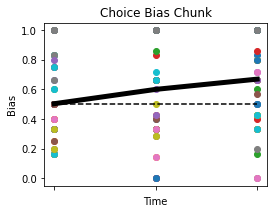

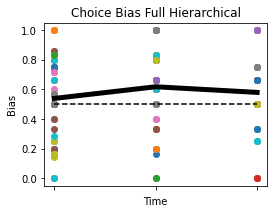

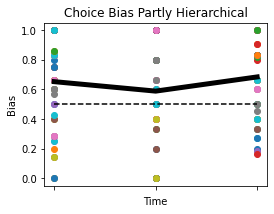

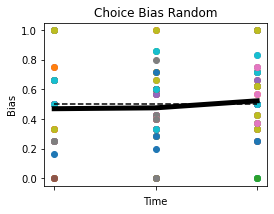

In [341]:
plt.rcParams['figure.figsize'] = [4, 3]

# print(debrief_chosen_sess_sub)
debrief_Changedata = np.zeros((len(ids),3,6)) # subjects x sessions x conditions
for idx_sub in np.arange(len(ids)):
  for idx_sess in np.arange(3):
    for idx_con in np.arange(6):
      # if idx_sub==0:
      #   print(np.sum(debrief_chosen_sess_sub[idx_sess,idx_sub,idx_con,:]))
      debrief_Changedata[idx_sub,idx_sess,idx_con] = np.divide(debrief_chosen_sess_sub[idx_sess,idx_sub,idx_con,0],
                                                               np.sum(debrief_chosen_sess_sub[idx_sess,idx_sub,idx_con,:]))
      
# debrief_Changedata[0,:,0]

# Titles_id_mean = np.array(ids)
# Titles_id_mean = np.append(Titles_id_mean,"mean")

# Chunk bias over time
debrief_chunk = debrief_Changedata[:,:,0]

# plt.boxplot(diff_mean_r_tt)
# plt.plot(np.transpose(diff_mean_r_tt,(1, 0)),'o')
plt.plot(np.transpose(debrief_chunk,(1, 0)),'o')
plt.plot(np.arange(0,3),np.mean(debrief_chunk,0),'k',linewidth=5)
plt.plot(np.arange(0,3),np.multiply(np.ones(3),0.5),'--k')
plt.xticks(np.arange(0,3), [])
plt.xlabel("Time")
plt.ylabel("Bias")
plt.title("Choice Bias Chunk")
plt.show()

# full hierarchy bias over time
debrief_fullH = debrief_Changedata[:,:,3]

# plt.boxplot(diff_mean_r_tt)
# plt.plot(np.transpose(diff_mean_r_tt,(1, 0)),'o')
plt.plot(np.transpose(debrief_fullH,(1, 0)),'o')
plt.plot(np.arange(0,3),np.mean(debrief_fullH,0),'k',linewidth=5)
plt.plot(np.arange(0,3),np.multiply(np.ones(3),0.5),'--k')
plt.xticks(np.arange(0,3), [])
plt.xlabel("Time")
plt.ylabel("Bias")
plt.title("Choice Bias Full Hierarchical")
plt.show()

# partly hierarchy bias over time
debrief_partH = debrief_Changedata[:,:,4]

# plt.boxplot(diff_mean_r_tt)
# plt.plot(np.transpose(diff_mean_r_tt,(1, 0)),'o')
plt.plot(np.transpose(debrief_partH,(1, 0)),'o')
plt.plot(np.arange(0,3),np.mean(debrief_partH,0),'k',linewidth=5)
plt.plot(np.arange(0,3),np.multiply(np.ones(3),0.5),'--k')
plt.xticks(np.arange(0,3), [])
plt.xlabel("Time")
plt.ylabel("Bias")
plt.title("Choice Bias Partly Hierarchical")
plt.show()

# random bias over time
debrief_random = debrief_Changedata[:,:,5]

# plt.boxplot(diff_mean_r_tt)
# plt.plot(np.transpose(diff_mean_r_tt,(1, 0)),'o')
plt.plot(np.transpose(debrief_random,(1, 0)),'o')
plt.plot(np.arange(0,3),np.mean(debrief_random,0),'k',linewidth=5)
plt.plot(np.arange(0,3),np.multiply(np.ones(3),0.5),'--k')
plt.xticks(np.arange(0,3), [])
plt.xlabel("Time")
plt.ylabel("Bias")
plt.title("Choice Bias Random")
plt.show()


## GLM: Change in choice bias over time

In [342]:
# GLM for these differences:
n_split = 3

# mode = "linear"
mode = "mean"

# chunk bias
data = np.transpose(debrief_chunk,(1, 0))
# design matrix: linear effect of time, mean
dm = np.concatenate((np.array(np.arange(n_split),ndmin=2).T,
                      np.array(np.ones(n_split),ndmin=2).T),1)
if mode=="linear":
  cm = np.array([1,0],ndmin=2) # linear effect
elif mode=="mean":
  cm = np.array([0,1],ndmin=2) # mean effect
betas,var_betas,tstat_betas = ols_PS(data,
                                    dm,
                                    cm)
# print(np.mean(betas))
if mode=="linear":
  test = stats.ttest_1samp(betas[0], 0)
elif mode=="mean":
  test = stats.ttest_1samp(betas[0], 0.5)
print("Choice bias chunk: " + 
      "t(" + str(np.size(betas,1)-1) + ")=" + str(test.statistic) +
      ", p=" + str(test.pvalue))

# Fully hierarchical vs. random bias
data = np.transpose(debrief_fullH,(1, 0))
# design matrix: linear effect of time, mean
dm = np.concatenate((np.array(np.arange(n_split),ndmin=2).T,
                      np.array(np.ones(n_split),ndmin=2).T),1)
if mode=="linear":
  cm = np.array([1,0],ndmin=2) # linear effect
elif mode=="mean":
  cm = np.array([0,1],ndmin=2) # mean effect
betas,var_betas,tstat_betas = ols_PS(data,
                                    dm,
                                    cm)
if mode=="linear":
  test = stats.ttest_1samp(betas[0], 0)
elif mode=="mean":
  test = stats.ttest_1samp(betas[0], 0.5)
print("Fully hierarchical bias: " + 
      "t(" + str(np.size(betas,1)-1) + ")=" + str(test.statistic) +
      ", p=" + str(test.pvalue))

# Partly hierarchical vs. random bias
data = np.transpose(debrief_partH,(1, 0))
# design matrix: linear effect of time, mean
dm = np.concatenate((np.array(np.arange(n_split),ndmin=2).T,
                      np.array(np.ones(n_split),ndmin=2).T),1)
if mode=="linear":
  cm = np.array([1,0],ndmin=2) # linear effect
elif mode=="mean":
  cm = np.array([0,1],ndmin=2) # mean effect
betas,var_betas,tstat_betas = ols_PS(data,
                                    dm,
                                    cm)

if mode=="linear":
  test = stats.ttest_1samp(betas[0], 0)
elif mode=="mean":
  test = stats.ttest_1samp(betas[0], 0.5)
print("Partly hierarchical bias: " + 
      "t(" + str(np.size(betas,1)-1) + ")=" + str(test.statistic) +
      ", p=" + str(test.pvalue))

# Random bias
data = np.transpose(debrief_random,(1, 0))
# design matrix: linear effect of time, mean
dm = np.concatenate((np.array(np.arange(n_split),ndmin=2).T,
                      np.array(np.ones(n_split),ndmin=2).T),1)
if mode=="linear":
  cm = np.array([1,0],ndmin=2) # linear effect
elif mode=="mean":
  cm = np.array([0,1],ndmin=2) # mean effect
betas,var_betas,tstat_betas = ols_PS(data,
                                    dm,
                                    cm)

if mode=="linear":
  test = stats.ttest_1samp(betas[0], 0)
elif mode=="mean":
  test = stats.ttest_1samp(betas[0], 0.5)
print("Random bias: " + 
      "t(" + str(np.size(betas,1)-1) + ")=" + str(test.statistic) +
      ", p=" + str(test.pvalue))

Choice bias chunk: t(49)=0.21186824456680678, p=0.8330886437169764
Fully hierarchical bias: t(49)=1.7317242581227605, p=0.08961470721943392
Partly hierarchical bias: t(49)=3.092502555697198, p=0.0032724583725403035
Random bias: t(49)=-1.100549986731871, p=0.27646986097590137


## Minesweeper

In [343]:
## Debriefing tasks
r = requests.get(API_URL+"/minesweeper_action")
print("Status:", r.status_code)
pd_data = []
minesweep_actions = json.loads(r.text)

print(minesweep_actions)

for d in minesweep_actions:
    record = [d["minsweeper_action_id"], d["session_id"], d["x"],d["y"],d["id"], d["reaction_time"], 
              d["selected"], d["silhouette"], d["solution"], d["trial_id"], d["experiment_part"], d["trialtype"]] 
    pd_data.append(record)
    
print("Found", len(pd_data), "minesweep_actions")
    
minesweep_actions_df = pd.DataFrame(pd_data, columns=["minsweeper_action_id","session_id","x","y","id","reaction_time", 
                                                      "selected","silhouette","solution","trial_id","experiment_part","trialtype"])
# minesweep_actions_df.head()
minesweep_actions_df.tail()

Output hidden; open in https://colab.research.google.com to view.

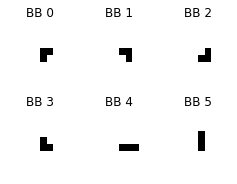

In [344]:
# define shape of primite building blocks:
def mkPlot_subplots_LinIdx(form_linIdx,n_grid=20,n_grid_reduced=10,title='Stim ',cols=3,rows=3):

  # uses linear indexing

  fig = plt.figure() 

  for idx_BB in np.arange(np.size(form_linIdx,0)):

    BB = np.zeros((n_grid,n_grid))
    BB[np.unravel_index(form_linIdx[idx_BB], (n_grid,n_grid), order='F')] = 1 

    fig.add_subplot(cols, rows, idx_BB+1)

    plt.imshow(BB, cmap='Greys')
    plt.axis('off')
    plt.title(title + str(idx_BB))

  plt.show()

starting_point = 55
n_grid = 10

form_BB = [
          [starting_point,   starting_point-1,          starting_point+(n_grid-1)],
          [starting_point-1, starting_point+(n_grid-1), starting_point+n_grid],
          [starting_point,   starting_point+n_grid,     starting_point+(n_grid-1)],
          [starting_point,   starting_point-1,          starting_point+n_grid],
          [starting_point,   starting_point+n_grid,     starting_point+n_grid*2],
          [starting_point,   starting_point-1,          starting_point-2]
          ]

n_grid_reduced = 10
mkPlot_subplots_LinIdx(form_BB,n_grid,n_grid_reduced,'BB ',2,3)

In [345]:
# those are the translations from a given coordinate of a building block
translations_BB = [
                  [[0,0], [1,0], [0,1]],
                  [[0,0], [1,0], [1,1]],
                  [[0,0], [0,1], [-1,1]],
                  [[0,0], [0,1], [1,1]],
                  [[0,0], [1,0], [2,0]],
                  [[0,0], [0,1], [0,2]],
                  ]

In [346]:
# stupid readout function of text-based silhouette description into coordinate form

def make_ShapeCoord(trial_Shape,n_BBs=3,start_pos=4):

  BBs = []

  for idx_BB in np.arange(n_BBs):

    BBs.append([int(trial_Shape[start_pos+(idx_BB*15)]),
                int(trial_Shape[start_pos+4+(idx_BB*15)]),
                int(trial_Shape[start_pos+9+(idx_BB*15)])])
    
  return BBs

In [347]:
# draw a silhoutte based on coordinate descriptions
# Input
# trial_ShapeCoord: coordinates of to-be-drawn buiding blocks (format: [x,y,building block id])
# translations_BB: translations needed to draw complete building block
# n_grid_reduced: size of grid
# BB_shape: if there's already a shape, empty grid otherwise
# add_val: which value to give to the grid elements

def draw_silh(trial_ShapeCoord,translations_BB,n_grid_reduced=10,BB_shape=[],add_val=1):

  if len(BB_shape)==0:
    BB = np.zeros((n_grid_reduced,n_grid_reduced)) # initialise empty grid
  else:
    BB = np.array(BB_shape)

  n_blocks = len(trial_ShapeCoord)

  for idx_block in np.arange(n_blocks):

    idx_block_translation = translations_BB[trial_ShapeCoord[idx_block][2]]

    for idx_translation in np.arange(len(idx_block_translation)):

      idx_draw = np.add(trial_ShapeCoord[idx_block][:2],idx_block_translation[idx_translation])

      BB[idx_draw[1],idx_draw[0]] = add_val

  # print(BB)

  return BB.astype(int)

In [348]:
#@title Helper function crop silhouette mkCrop()
# returns form without additional padding, also size info
def mkCrop(FORM,output='reduced'):

  min_x = np.min(np.where(np.sum(FORM,axis=0)!=0))
  max_x = np.max(np.where(np.sum(FORM,axis=0)!=0))

  min_y = np.min(np.where(np.sum(FORM,axis=1)!=0))
  max_y = np.max(np.where(np.sum(FORM,axis=1)!=0))

  FORM_crop = FORM[min_y:max_y+1,min_x:max_x+1]

  range_x = max_x - min_x + 1;
  range_y = max_y - min_y + 1;

  if output == 'full':
    return FORM_crop, range_x, range_y, min_x, max_x, min_y, max_y
  elif output == 'reduced':
    return FORM_crop

In [349]:
#@title Helper function overlap, size_diff, overlap, size_1, size_2 = mk_vis_overlap()


def mk_vis_overlap(Form_1,Form_2):
  # expects cropped forms

  size_1 = np.shape(Form_1)
  size_2 = np.shape(Form_2)

  if size_1[0]==size_2[0] and size_1[1]==size_2[1]:

    y_diff = 0
    x_diff = 0
    Form_xy = np.add(Form_1,Form_2)
    overlap = np.sum(Form_xy[Form_xy==2])/np.sum(Form_xy[Form_xy>0])

  else:

    y_diff = np.max([size_1[0],size_2[0]])-np.min([size_1[0],size_2[0]])
    y_pad = np.arange(0,y_diff+1)

    x_diff = np.max([size_1[1],size_2[1]])-np.min([size_1[1],size_2[1]])
    x_pad = np.arange(0,x_diff+1)

    overlap = []

    for y_move in y_pad:
      for x_move in x_pad:
        if size_1[0]<=size_2[0] and size_1[1]<=size_2[1]:
          Form_1_pad = np.pad(Form_1, ((y_move, y_diff-y_move), (0, 0)), 'constant', constant_values=0)
          Form_1_pad = np.pad(Form_1_pad, ((0, 0), (x_move, x_diff-x_move)), 'constant', constant_values=0)
          Form_2_pad = Form_2
        elif size_1[0]<=size_2[0] and size_1[1]>size_2[1]:
          Form_1_pad = np.pad(Form_1, ((y_move, y_diff-y_move), (0, 0)), 'constant', constant_values=0)
          Form_2_pad = np.pad(Form_2, ((0, 0), (x_move, x_diff-x_move)), 'constant', constant_values=0)
        elif size_1[0]>size_2[0] and size_1[1]<=size_2[1]:
          Form_1_pad = np.pad(Form_1, ((0, 0), (x_move, x_diff-x_move)), 'constant', constant_values=0)
          Form_2_pad = np.pad(Form_2, ((y_move, y_diff-y_move), (0, 0)), 'constant', constant_values=0)
        elif size_1[0]>size_2[0] and size_1[1]>size_2[1]:
          Form_1_pad = Form_1
          Form_2_pad = np.pad(Form_2, ((y_move, y_diff-y_move), (0, 0)), 'constant', constant_values=0)
          Form_2_pad = np.pad(Form_2_pad, ((0, 0), (x_move, x_diff-x_move)), 'constant', constant_values=0)

        Form_xy = np.add(Form_1_pad,Form_2_pad)

        overlap = np.append(overlap,np.sum(Form_xy[Form_xy==2])/np.sum(Form_xy[Form_xy>0]))

  overlap = np.round(overlap,2)

  # print(np.max(overlap),np.round((y_diff+x_diff)/2,2))

  # visual overlap is defined as the max overlap under all possible translations (values between 0 and 1 = identical)
  # size overlap is average size difference (0 = same size to +inf)
  return np.max(overlap), np.round((y_diff+x_diff)/2,2), overlap, size_1, size_2

In [350]:
plt.rcParams['figure.figsize'] = [15, 5]

# ids = [225,227,262,265] # this is pilot
# ids = [530,531,532,533,535] # stim set 0, prolific only
# ids = [531]
# ids = [530,531,532,533,535,548] # stim set 0, all subs
# ids = [554,555,556,557,558] # stim set 0, prolific only

# ids_use = [ids[0]]
ids_use = np.array(ids)

# stim set 0 chunks: [0,1], [3,5] 
# stim set 1 chunks: [4,5], [3,2]
# chunk_0 = [0,1]
# chunk_1 = [3,5]

# coordinates: y is dominant, find minimum y coordinate (row), then minimum x (column) therein

# n_stims = 63 # clumsy
# n_stims = 10 # clumsy
# n_stims = 2 # clumsy

# n_unique_stims = 18; # clumsy
# n_unique_stims = 45; # clumsy
n_unique_stims = 52; # clumsy

n_grid_reduced = 10

# make a color map of fixed colors
cmap_PS = colors.ListedColormap(['white','darkgrey','black','limegreen'])
bounds=[0,1,2,3]
norm = colors.BoundaryNorm(bounds, cmap_PS.N)

cols = 7
rows = 9

silhouettes_unique_allSubs = np.zeros((n_unique_stims,n_grid_reduced,n_grid_reduced))

# trialtype_uniq = ['11' '1161' '14' '142' '144' '16' '169' '17' '173' '18' '195' '2118'
#  '2124' '23' '256' '260' '6' '7']

#  trialtype_uniq = [6,7,11,14,16,17,18,
#                    42,44,69,73,95,161
#                    3,56,60,118,124]

# trialtype_uniq = [6,7,11,14,16,17,18,
#                   142,144,169,173,195,1161,
#                   23,256,260,2118,2124]  

# trialtype_uniq = ['6','7','11','14','16','17','18',
#                   '142','144','169','173','195','1161',
#                   '23','256','260','2118','2124']                              

# proportion correct building block usage
prop_correct_sub = []
prop_correct_sub_fullH = []
prop_correct_sub_partH = []

# proportion correct DRAWING
prop_correctDrawing_sub = []
prop_correctDrawing_sub_fullH = []
prop_correctDrawing_sub_partH = []

# proportion overlap DRAWING
prop_overlapDrawing_sub = []
prop_overlapDrawing_sub_fullH = []
prop_overlapDrawing_sub_partH = []

for session_id in ids_use:
# for session_id in [ids_use[0]]:
    # print("\nSubject ", session_id)
    trials = minesweep_actions_df[minesweep_actions_df['session_id'] == session_id]

    trial_id       = trials["trial_id"].to_numpy()
    shape_id       = trials["silhouette"].to_numpy()
    solution_id    = trials["solution"].to_numpy() 
    trialtype      = trials["trialtype"].to_numpy()
    # trialtype_uniq = np.unique(trialtype)
    trialtype_uniq = trialtype
    # print(trialtype_uniq)

    # trialtype_uniq = np.array(['6','7','11','14','16','17','18','142','144','169','173','195','1161','23','256','260','2118','2124'])
    # print(trialtype_uniq)

    silhouettes_unique       = np.zeros((len(trialtype_uniq),n_grid_reduced,n_grid_reduced))
    silhouettes_unique_sol   = np.zeros((len(trialtype_uniq),n_grid_reduced,n_grid_reduced))
    silhouettes_unique_count = np.zeros((len(trialtype_uniq)))
    
    x_draw        = trials["x"].to_numpy()
    y_draw        = trials["y"].to_numpy()
    id_draw       = trials["id"].to_numpy()
    selected_draw = trials["selected"].to_numpy()    

    correct_id = []

    # fig = plt.figure()

    trial_id_unique = np.unique(trial_id)

    stim_Name = trial_id_unique[0][:-1]  

    # print(stim_Name)

    n_stims = len(trialtype)

    trial_types_sub = []
    overlap_sub = []

    for idx_stim in np.arange(0,n_stims):
      idx_Trials = np.where(trial_id == stim_Name + str(idx_stim))[0]

      # print(idx_Trials)

      trial_Shape     = shape_id[idx_Trials[0]]
      trial_Solution  = solution_id[idx_Trials[0]]
      trial_trialtype = trialtype[idx_Trials[0]]
      trial_ShapeCoord    = make_ShapeCoord(trial_Shape)
      trial_SolutionCoord = make_ShapeCoord(trial_Solution,1,3)         

      correct_id.append(int(trial_Solution[-2]))
      
      BB_draw = np.array(draw_silh(trial_ShapeCoord,translations_BB,n_grid_reduced)) # draw given silhouette

      # if idx_stim == 0:
      #   print(BB_draw)

      # BB_draw = draw_silh(trial_SolutionCoord,translations_BB,n_grid_reduced,BB_draw,2) # add solution

      # idx_trialtype_uniq = np.where(trial_trialtype == trialtype_uniq)[0]
      idx_trialtype_uniq = idx_Trials[0]

      silhouettes_unique_count[idx_trialtype_uniq] += 1
      # silhouettes_unique_sol[idx_trialtype_uniq,:,:] = np.array(draw_silh(trial_SolutionCoord,translations_BB,n_grid_reduced,BB_draw,2)) # add solution
      if silhouettes_unique_count[idx_trialtype_uniq] == 1:
        silhouettes_unique_sol[idx_trialtype_uniq,:,:] = np.array(draw_silh(trial_SolutionCoord,translations_BB,n_grid_reduced,BB_draw,2)) # add solution
      else:
        prev_Sol = np.array(silhouettes_unique_sol[idx_trialtype_uniq,:,:])[0]
        add_Sol = np.array(draw_silh(trial_SolutionCoord,translations_BB,n_grid_reduced,BB_draw,2)) # add solution
        # print(prev_Sol)
        # print(add_Sol)
        prev_Sol[add_Sol==2] = 2
        silhouettes_unique_sol[idx_trialtype_uniq,:,:] = np.array(prev_Sol)
        # silhouettes_unique_sol[idx_trialtype_uniq,:,:] = np.add(silhouettes_unique[idx_trialtype_uniq,:,:],BB_draw)
        # print(trial_SolutionCoord)

      # if idx_stim == 0:
      #   print(BB_draw)
      #   print(silhouettes_unique_sol[idx_trialtype_uniq,:,:])
      # for idx_draw in idx_Trials:
      #   BB_draw[y_draw[idx_draw],x_draw[idx_draw]] = 3 * int(selected_draw[idx_draw])

      # fig.add_subplot(rows, cols, idx_stim+1)
      # plt.imshow(BB_draw, cmap=cmap_PS)
      # plt.axis('off')

      # Find trial drawing
      draw_TrialCoord = [x_draw[idx_Trials[0]],y_draw[idx_Trials[0]],int(id_draw[idx_Trials[0]])]
      # print(draw_TrialCoord)
      drawing_Trial = np.array(draw_silh([draw_TrialCoord],translations_BB,n_grid_reduced,BB_draw,3)) # add solution
      # print(drawing_Trial)
      
      # if idx_stim == 0:
      #   print(BB_draw)
      #   print(silhouettes_unique_sol[idx_trialtype_uniq,:,:])
      #   print(drawing_Trial)

      # store in unique silhouette
      if silhouettes_unique_count[idx_trialtype_uniq] == 1:
        # BB_draw[BB_draw==2] = 0 # remove all solutions
        # silhouettes_unique[idx_trialtype_uniq,:,:] = np.add(silhouettes_unique[idx_trialtype_uniq,:,:],BB_draw)
        silhouettes_unique[idx_trialtype_uniq,:,:] = drawing_Trial
      else:
        # BB_draw[BB_draw!=3] = 0 # remove everything except drawings
        # silhouettes_unique[idx_trialtype_uniq,:,:] = np.add(silhouettes_unique[idx_trialtype_uniq,:,:],BB_draw)
        drawing_Trial[drawing_Trial==1] = 0
        silhouettes_unique[idx_trialtype_uniq,:,:] = np.add(silhouettes_unique[idx_trialtype_uniq,:,:],drawing_Trial)

      # print(trialtype_uniq[idx_trialtype_uniq])
      # print(drawing_Trial)
      # print(silhouettes_unique[idx_trialtype_uniq,:,:])

      # now gather all silhouettes across subjects
      if session_id == ids_use[0]:
        sil_add = np.array(silhouettes_unique[idx_trialtype_uniq,:,:])
      else:
        sil_add = np.array(silhouettes_unique[idx_trialtype_uniq,:,:])
        sil_add[sil_add==1] = 0

      silhouettes_unique_allSubs[idx_trialtype_uniq,:,:] = np.add(silhouettes_unique_allSubs[idx_trialtype_uniq,:,:],sil_add)

      if int(trial_trialtype[0])==0:
        trial_types_sub.append(0)        
      elif int(trial_trialtype[0])==1:
        trial_types_sub.append(1)

      # find overlap drawing and solution:
      add_Sol = np.array(draw_silh(trial_SolutionCoord,translations_BB,n_grid_reduced))
      drawing_Trial = np.array(draw_silh([draw_TrialCoord],translations_BB,n_grid_reduced))
      # if idx_stim == 0:
      #   print(add_Sol)
      #   print(drawing_Trial)
      Form_xy = np.add(add_Sol,drawing_Trial)
      overlap = np.sum(Form_xy[Form_xy==2])/np.sum(Form_xy[Form_xy>0])
      # overlap, _, _, _, _ = mk_vis_overlap(mkCrop(add_Sol),mkCrop(drawing_Trial))
      # print(overlap)

      overlap_sub.append(overlap)

    trial_types_sub = np.array(trial_types_sub)
    # print(trial_types_sub)

    idx_fullH = np.where(trial_types_sub==0)[0]
    idx_partH = np.where(trial_types_sub==1)[0]
    # print(idx_fullH)

    # plt.tight_layout()
    # plt.show()

    # print(id_draw)
    # print(correct_id)
    # np.where( (arrayA==0) & (arrayB==0))
    # print(np.intersect1d(id_draw,correct_id))
    # print(len(np.where(id_draw==correct_id)[0])/len(correct_id))
        
    # find usage of correct building blocks:
    correct_id = np.array(correct_id)

    prop_correct_sub.append(len(np.where(id_draw==correct_id)[0])/len(correct_id)) 

    prop_correct_sub_fullH.append(len(np.where(id_draw[idx_fullH]==correct_id[idx_fullH])[0])/len(correct_id[idx_fullH]))

    if session_id>744:
      prop_correct_sub_partH.append(len(np.where(id_draw[idx_partH]==correct_id[idx_partH])[0])/len(correct_id[idx_partH]))

    # find correct drawing (really hard!)
    overlap_sub = np.array(overlap_sub)

    prop_correctDrawing_sub.append(len(np.where(overlap_sub==1)[0])/len(overlap_sub)) 

    prop_correctDrawing_sub_fullH.append(len(np.where(overlap_sub[idx_fullH]==1)[0])/len(overlap_sub[idx_fullH])) 

    if session_id>744:
      prop_correctDrawing_sub_partH.append(len(np.where(overlap_sub[idx_partH]==1)[0])/len(overlap_sub[idx_partH])) 

    # find overlap drawing

    prop_overlapDrawing_sub.append(np.mean(overlap_sub))
    prop_overlapDrawing_sub_fullH.append(np.mean(overlap_sub[idx_fullH]))
    if session_id>744:
      prop_overlapDrawing_sub_partH.append(np.mean(overlap_sub[idx_partH]))

    # now plot:
    if plot_indiv and session_id==ids[-1]:
      rows = 7
      cols = 15

      Cols_plot_solution = ['white','black','limegreen']
      Cols_plot = ['white','black','mistyrose','lightsalmon','tomato','red','darkred']
      # Cols_plot = [[1,1,1],[0,0,0]]
      # for col_idx in np.linspace(0.7,0.95,5):
      #   Cols_plot.append([col_idx,0.7,0.7]) 

      fig = plt.figure()

      fig_count = 1

      for idx_unique in np.arange(len(trialtype_uniq)):
        
        fig.add_subplot(rows, cols, fig_count)

        silhouettes_plot = np.array(silhouettes_unique[idx_unique,:,:])
        silhouettes_plot[silhouettes_unique_sol[idx_unique,:,:]==1] = 1
        unique_ValsSil = np.unique(silhouettes_plot)
        for idx_ValsSil in np.arange(0,len(unique_ValsSil)):
          silhouettes_plot[silhouettes_plot==unique_ValsSil[idx_ValsSil]] = idx_ValsSil      

        cmap_PS = colors.ListedColormap(Cols_plot[:len(unique_ValsSil)])
        plt.imshow(silhouettes_plot, cmap=cmap_PS)
        plt.axis('off')
        fig_count += 1

        # print(silhouettes_plot)

        fig.add_subplot(rows, cols, fig_count)
        cmap_PS = colors.ListedColormap(Cols_plot_solution)
        plt.imshow(silhouettes_unique_sol[idx_unique,:,:], cmap=cmap_PS)
        plt.axis('off')
        fig_count += 1

    if plot_indiv:
      plt.tight_layout()
      plt.show()

# # now plot all:
# print("All subjects")
# rows = 7
# cols = 15

# Cols_plot_solution = ['white','black','limegreen']
# # Cols_plot = ['white','black','seashell','mistyrose','peachpuff','pink','lighsalmon','salmon','darksalmon','lightcoral','coral','tomato','indianred',
# #              'brown','firebrick','maroon','darkred']
# # Cols_plot = [[1,1,1],[0,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0],
# #              [1,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0]]

# Cols_plot = [[1,1,1],[0,0,0]]
# for col_idx in np.linspace(0.7,0.95,20):
#   Cols_plot.append([col_idx,0.7,0.7])           

# fig = plt.figure()

# fig_count = 1

# for idx_unique in np.arange(len(trialtype_uniq)):
  
#   fig.add_subplot(rows, cols, fig_count)

#   silhouettes_plot = np.array(silhouettes_unique_allSubs[idx_unique,:,:])
#   silhouettes_plot[silhouettes_unique_sol[idx_unique,:,:]==1] = 1
#   unique_ValsSil = np.unique(silhouettes_plot)
#   for idx_ValsSil in np.arange(0,len(unique_ValsSil)):
#     silhouettes_plot[silhouettes_plot==unique_ValsSil[idx_ValsSil]] = idx_ValsSil  

#   # print(silhouettes_plot)

#   cmap_PS = colors.ListedColormap(Cols_plot[:len(unique_ValsSil)])
#   # cmap_PS = colors.ListedColormap(Cols_plot)
#   plt.imshow(silhouettes_plot, cmap=cmap_PS)
#   # cmap_PS = colors.ListedColormap(Cols_plot)
#   # plt.imshow(silhouettes_plot, cmap=newcmp)
#   plt.axis('off')
#   fig_count += 1

#   fig.add_subplot(rows, cols, fig_count)
#   cmap_PS = colors.ListedColormap(Cols_plot_solution)
#   plt.imshow(silhouettes_unique_sol[idx_unique,:,:], cmap=cmap_PS)
#   plt.axis('off')
#   fig_count += 1

# plt.tight_layout() or 
# plt.show()

# print(silhouettes_unique_allSubs[0,:,:])

print(prop_correct_sub)
print(prop_correct_sub_fullH)
print(prop_correct_sub_partH)
print(prop_correctDrawing_sub)
print(prop_correctDrawing_sub_fullH)
print(prop_correctDrawing_sub_partH)
print(prop_overlapDrawing_sub)
print(prop_overlapDrawing_sub_fullH)
print(prop_overlapDrawing_sub_partH)

[0.36666666666666664, 0.7666666666666667, 0.7333333333333333, 0.5666666666666667, 0.26666666666666666, 0.2, 0.7666666666666667, 0.26666666666666666, 0.9333333333333333, 0.7, 0.35555555555555557, 0.4888888888888889, 0.28888888888888886, 0.2, 0.4, 0.13333333333333333, 0.6888888888888889, 0.35555555555555557, 0.2, 0.9777777777777777, 0.17777777777777778, 0.5111111111111111, 0.7333333333333333, 0.5111111111111111, 0.13333333333333333, 0.4444444444444444, 0.5111111111111111, 0.6888888888888889, 0.5777777777777777, 0.37777777777777777, 0.6666666666666666, 0.09615384615384616, 0.5384615384615384, 0.4423076923076923, 0.5384615384615384, 0.40384615384615385, 0.19230769230769232, 0.2692307692307692, 0.23076923076923078, 0.057692307692307696, 0.8269230769230769, 0.8076923076923077, 0.9423076923076923, 0.1346153846153846, 0.1346153846153846, 0.40384615384615385, 0.4807692307692308, 0.7115384615384616, 0.5576923076923077, 0.8269230769230769]
[0.36666666666666664, 0.7666666666666667, 0.7333333333333

## Plot Proportion of correct usage of BBs

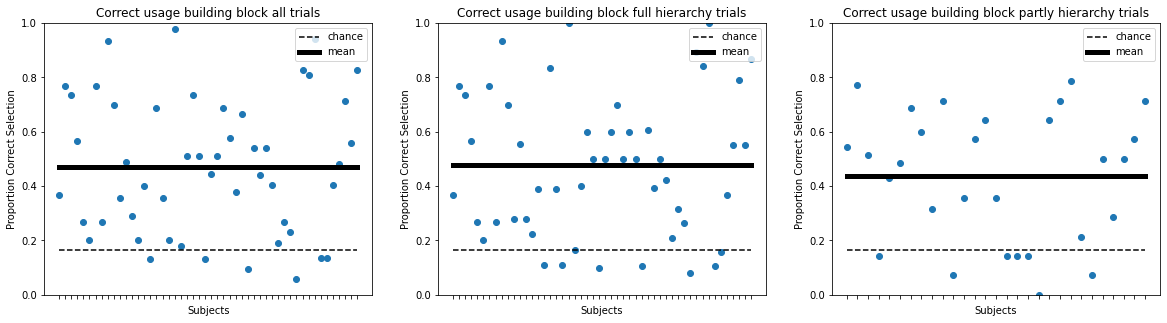

In [351]:
from numpy.lib.shape_base import column_stack
plt.rcParams['figure.figsize'] = [20, 5]

rows = 1
cols = 3

fig = plt.figure()

# Plot all data
fig_count = 1
fig.add_subplot(rows, cols, fig_count)

plt.plot(prop_correct_sub,'o')

plt.plot(np.arange(0,len(prop_correct_sub)),
         np.multiply(np.ones(len(prop_correct_sub)),1/6),
         '--k',
         label='chance')

plt.plot(np.arange(0,len(prop_correct_sub)),
         np.multiply(np.ones(len(prop_correct_sub)),np.mean(prop_correct_sub)),
         'k',linewidth=5,
         label='mean')

plt.xticks(np.arange(0,len(prop_correct_sub)), [])
plt.xlabel("Subjects")
plt.ylabel("Proportion Correct Selection")
plt.title("Correct usage building block all trials")
plt.ylim(0,1)
plt.legend(loc='upper right')

# Plot fully hierarchical data
fig_count = 2
fig.add_subplot(rows, cols, fig_count)

plt.plot(prop_correct_sub_fullH,'o')

plt.plot(np.arange(0,len(prop_correct_sub_fullH)),
         np.multiply(np.ones(len(prop_correct_sub_fullH)),1/6),
         '--k',
         label='chance')

plt.plot(np.arange(0,len(prop_correct_sub_fullH)),
         np.multiply(np.ones(len(prop_correct_sub_fullH)),np.mean(prop_correct_sub_fullH)),
         'k',linewidth=5,
         label='mean')

plt.xticks(np.arange(0,len(prop_correct_sub_fullH)), [])
plt.xlabel("Subjects")
plt.ylabel("Proportion Correct Selection")
plt.title("Correct usage building block full hierarchy trials")
plt.ylim(0,1)
plt.legend(loc='upper right')

# Plot fully hierarchical data
fig_count = 3
fig.add_subplot(rows, cols, fig_count)

plt.plot(prop_correct_sub_partH,'o')

plt.plot(np.arange(0,len(prop_correct_sub_partH)),
         np.multiply(np.ones(len(prop_correct_sub_partH)),1/6),
         '--k',
         label='chance')

plt.plot(np.arange(0,len(prop_correct_sub_partH)),
         np.multiply(np.ones(len(prop_correct_sub_partH)),np.mean(prop_correct_sub_partH)),
         'k',linewidth=5,
         label='mean')

plt.xticks(np.arange(0,len(prop_correct_sub_partH)), [])
plt.xlabel("Subjects")
plt.ylabel("Proportion Correct Selection")
plt.title("Correct usage building block partly hierarchy trials")
plt.ylim(0,1)
plt.legend(loc='upper right')

plt.show()

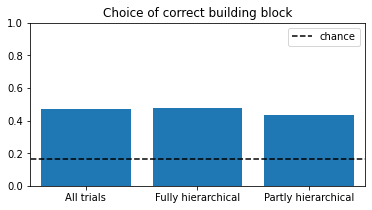

In [352]:
plt.rcParams['figure.figsize'] = [6, 3]

plt.bar([0,1,2], 
        [np.mean(prop_correct_sub),np.mean(prop_correct_sub_fullH),np.mean(prop_correct_sub_partH)])

plt.plot([-1,1,3],
         np.multiply(np.ones(3),1/6),
         '--k',
         label='chance')

plt.xticks(np.arange(0,3), ["All trials","Fully hierarchical","Partly hierarchical"])
plt.title("Choice of correct building block") 
plt.ylim(0, 1) 
plt.xlim(-.5, 2.5)  
plt.legend(loc='upper right')

plt.show() 

## T test for correct building block in minesweeper

In [354]:
# for all trials
test = stats.ttest_1samp(prop_correct_sub, 1/6)
print("All trials: " + 
      "t(" + str(np.size(chunk_bias,0)-1) + ")=" + str(test.statistic) +
      ", p=" + str(test.pvalue))

# for fully hierarchical
test = stats.ttest_1samp(prop_correct_sub_fullH, 1/6)
print("Fully hierarchical: " + 
      "t(" + str(np.size(fullH_bias,0)-1) + ")=" + str(test.statistic) +
      ", p=" + str(test.pvalue))

# for partly hierarchical
test = stats.ttest_1samp(prop_correct_sub_partH, 1/6)
print("Partly hierarchical: " + 
      "t(" + str(np.size(partH_bias,0)-1) + ")=" + str(test.statistic) +
      ", p=" + str(test.pvalue))

All trials: t(49)=8.596996565865966, p=2.3694644839256503e-11
Fully hierarchical: t(49)=8.353938438154639, p=5.5230419749535484e-11
Partly hierarchical: t(49)=6.044998588771319, p=1.6215379202524484e-06


## Plot Proportion of Correct Drawings

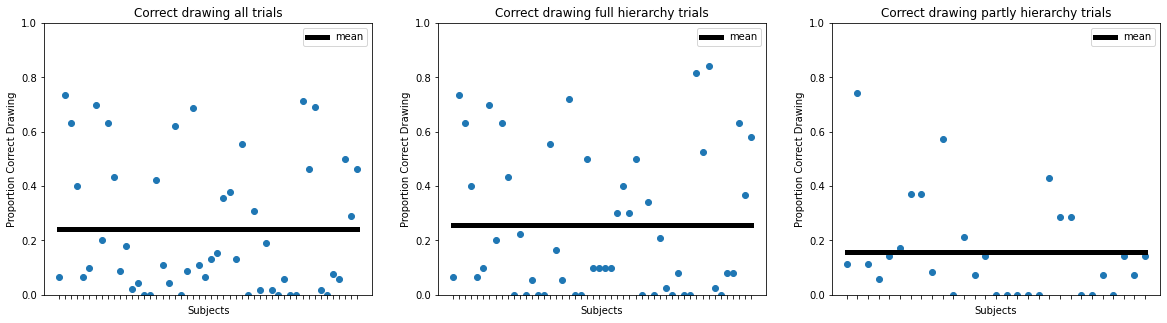

In [355]:
from numpy.lib.shape_base import column_stack
plt.rcParams['figure.figsize'] = [20, 5]

rows = 1
cols = 3

fig = plt.figure()

# Plot all data
fig_count = 1
fig.add_subplot(rows, cols, fig_count)

plt.plot(prop_correctDrawing_sub,'o')

plt.plot(np.arange(0,len(prop_correctDrawing_sub)),
         np.multiply(np.ones(len(prop_correctDrawing_sub)),np.mean(prop_correctDrawing_sub)),
         'k',linewidth=5,
         label='mean')

plt.xticks(np.arange(0,len(prop_correctDrawing_sub)), [])
plt.xlabel("Subjects")
plt.ylabel("Proportion Correct Drawing")
plt.title("Correct drawing all trials")
plt.ylim(0,1)
plt.legend(loc='upper right')

# Plot fully hierarchical data
fig_count = 2
fig.add_subplot(rows, cols, fig_count)

plt.plot(prop_correctDrawing_sub_fullH,'o')

plt.plot(np.arange(0,len(prop_correctDrawing_sub_fullH)),
         np.multiply(np.ones(len(prop_correctDrawing_sub_fullH)),np.mean(prop_correctDrawing_sub_fullH)),
         'k',linewidth=5,
         label='mean')

plt.xticks(np.arange(0,len(prop_correctDrawing_sub_fullH)), [])
plt.xlabel("Subjects")
plt.ylabel("Proportion Correct Drawing")
plt.title("Correct drawing full hierarchy trials")
plt.ylim(0,1)
plt.legend(loc='upper right')

# Plot fully hierarchical data
fig_count = 3
fig.add_subplot(rows, cols, fig_count)

plt.plot(prop_correctDrawing_sub_partH,'o')

plt.plot(np.arange(0,len(prop_correctDrawing_sub_partH)),
         np.multiply(np.ones(len(prop_correctDrawing_sub_partH)),np.mean(prop_correctDrawing_sub_partH)),
         'k',linewidth=5,
         label='mean')

plt.xticks(np.arange(0,len(prop_correctDrawing_sub_partH)), [])
plt.xlabel("Subjects")
plt.ylabel("Proportion Correct Drawing")
plt.title("Correct drawing partly hierarchy trials")
plt.ylim(0,1)
plt.legend(loc='upper right')

plt.show()

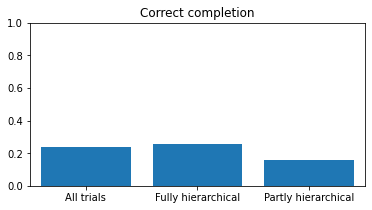

In [356]:
plt.rcParams['figure.figsize'] = [6, 3]

plt.bar([0,1,2], 
        [np.mean(prop_correctDrawing_sub),np.mean(prop_correctDrawing_sub_fullH),np.mean(prop_correctDrawing_sub_partH)])

# plt.plot([-1,1,3],
#          np.multiply(np.ones(3),1/6),
#          '--k',
#          label='chance')

plt.xticks(np.arange(0,3), ["All trials","Fully hierarchical","Partly hierarchical"])
plt.title("Correct completion") 
plt.ylim(0, 1) 
plt.xlim(-.5, 2.5)  
# plt.legend(loc='upper right')

plt.show() 

## T test for prop correct drawings

In [357]:
# for all trials
test = stats.ttest_1samp(prop_correctDrawing_sub, 0)
print("All trials: " + 
      "t(" + str(np.size(chunk_bias,0)-1) + ")=" + str(test.statistic) +
      ", p=" + str(test.pvalue))

# for fully hierarchical
test = stats.ttest_1samp(prop_correctDrawing_sub_fullH, 0)
print("Fully hierarchical: " + 
      "t(" + str(np.size(fullH_bias,0)-1) + ")=" + str(test.statistic) +
      ", p=" + str(test.pvalue))

# for partly hierarchical
test = stats.ttest_1samp(prop_correctDrawing_sub_partH, 0)
print("Partly hierarchical: " + 
      "t(" + str(np.size(partH_bias,0)-1) + ")=" + str(test.statistic) +
      ", p=" + str(test.pvalue))

All trials: t(49)=6.888446282401632, p=9.875915360499652e-09
Fully hierarchical: t(49)=6.763873442777626, p=1.5403998937650755e-08
Partly hierarchical: t(49)=4.5646051714142795, p=9.111698392475887e-05


## Plot proportion overlap drawings

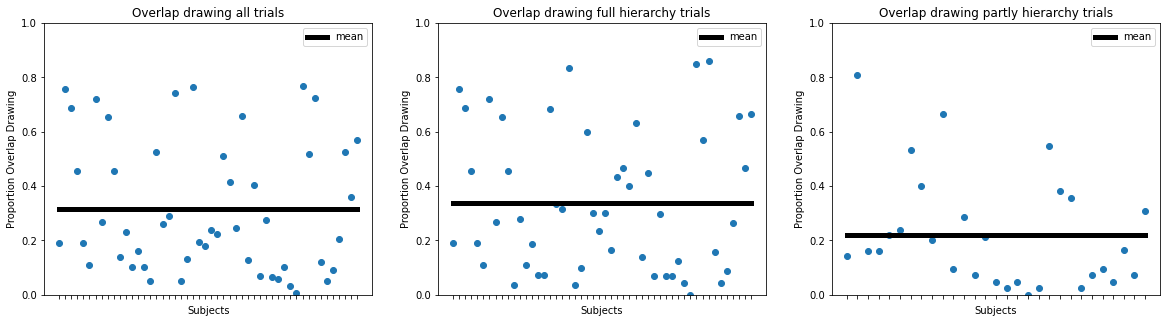

In [ ]:
plt.rcParams['figure.figsize'] = [20, 5]

rows = 1
cols = 3

fig = plt.figure()

# Plot all data
fig_count = 1
fig.add_subplot(rows, cols, fig_count)

plt.plot(prop_overlapDrawing_sub,'o')

plt.plot(np.arange(0,len(prop_overlapDrawing_sub)),
         np.multiply(np.ones(len(prop_overlapDrawing_sub)),np.mean(prop_overlapDrawing_sub)),
         'k',linewidth=5,
         label='mean')

plt.xticks(np.arange(0,len(prop_overlapDrawing_sub)), [])
plt.xlabel("Subjects")
plt.ylabel("Proportion Overlap Drawing")
plt.title("Overlap drawing all trials")
plt.ylim(0,1)
plt.legend(loc='upper right')

# Plot fully hierarchical data
fig_count = 2
fig.add_subplot(rows, cols, fig_count)

plt.plot(prop_overlapDrawing_sub_fullH,'o')

plt.plot(np.arange(0,len(prop_overlapDrawing_sub_fullH)),
         np.multiply(np.ones(len(prop_overlapDrawing_sub_fullH)),np.mean(prop_overlapDrawing_sub_fullH)),
         'k',linewidth=5,
         label='mean')

plt.xticks(np.arange(0,len(prop_overlapDrawing_sub_fullH)), [])
plt.xlabel("Subjects")
plt.ylabel("Proportion Overlap Drawing")
plt.title("Overlap drawing full hierarchy trials")
plt.ylim(0,1)
plt.legend(loc='upper right')

# Plot fully hierarchical data
fig_count = 3
fig.add_subplot(rows, cols, fig_count)

plt.plot(prop_overlapDrawing_sub_partH,'o')

plt.plot(np.arange(0,len(prop_overlapDrawing_sub_partH)),
         np.multiply(np.ones(len(prop_overlapDrawing_sub_partH)),np.mean(prop_overlapDrawing_sub_partH)),
         'k',linewidth=5,
         label='mean')

plt.xticks(np.arange(0,len(prop_overlapDrawing_sub_partH)), [])
plt.xlabel("Subjects")
plt.ylabel("Proportion Overlap Drawing")
plt.title("Overlap drawing partly hierarchy trials")
plt.ylim(0,1)
plt.legend(loc='upper right')

plt.show()

## Final Probe Q

In [ ]:
## Final Qs
r = requests.get(API_URL+"/drawing_action")
print("Status:", r.status_code)
pd_data = []
drawing_action = json.loads(r.text)

# print(drawing_action)

for d in drawing_action:
    record = [d["drawing_action_id"],d["session_id"],d["grid"],d["x"],d["y"],d["reaction_time"],d["selected"]] 
    pd_data.append(record)
    
print("Found", len(pd_data), "drawing_action")
    
drawing_action_df = pd.DataFrame(pd_data, columns=["drawing_action_id","session_id","grid","x","y","reaction_time", 
                                                      "selected"])
# drawing_action_df.head()
drawing_action_df.tail()

Status: 200
Found 6508 drawing_action


drawing_action_id  session_id  grid  x  y  reaction_time  selected
6503               6504         796     5  4  5          0.369       1.0
6504               6505         796     5  5  5          0.483       1.0
6505               6506         796     5  6  4          1.846       1.0
6506               6507         796     5  6  5          0.566       1.0
6507               6508         796     5  6  6          0.353       1.0


Subject  685


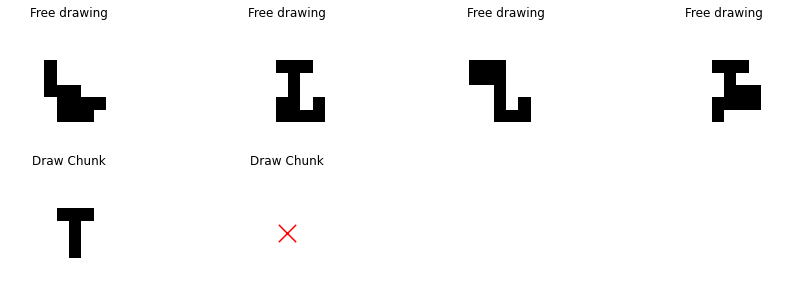


Subject  686


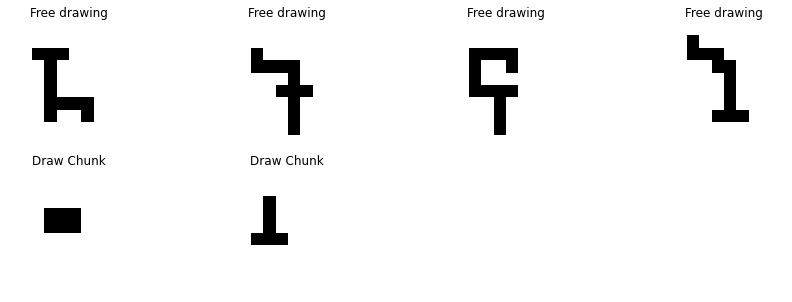


Subject  687


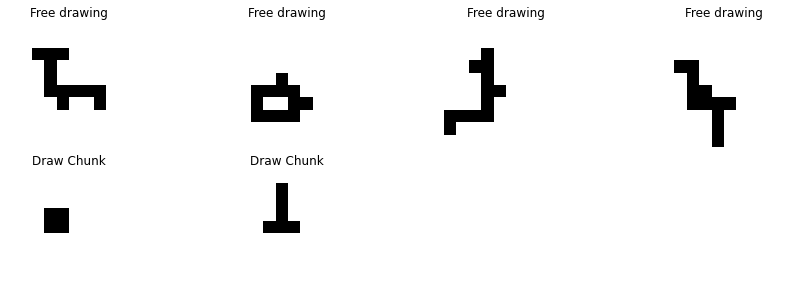


Subject  689


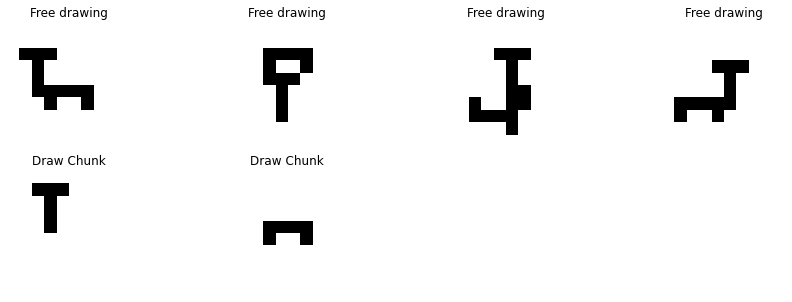


Subject  690


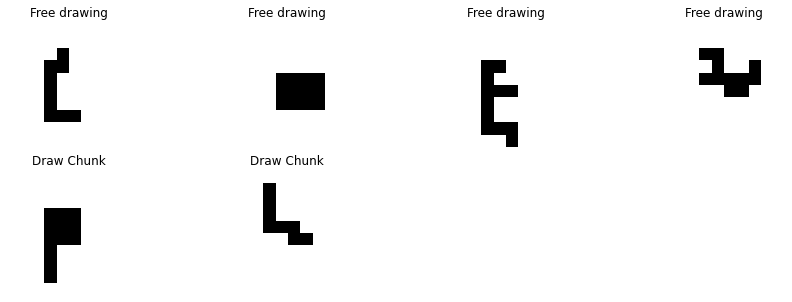


Subject  691


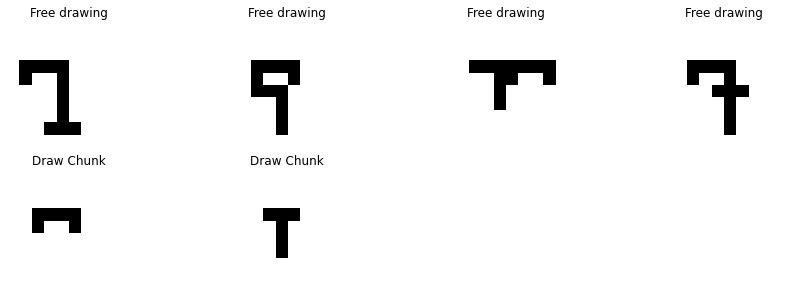


Subject  692


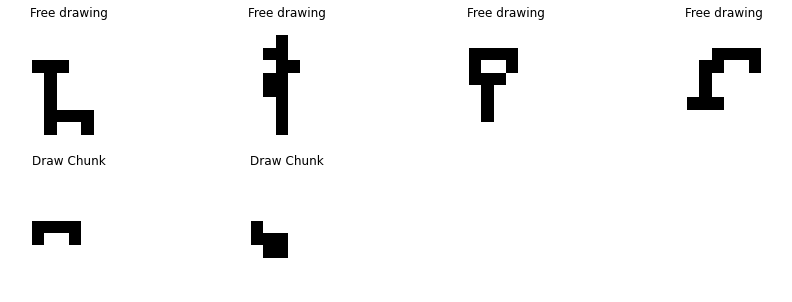


Subject  694


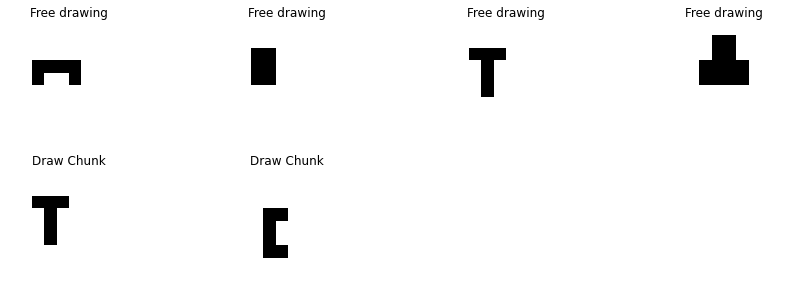


Subject  695


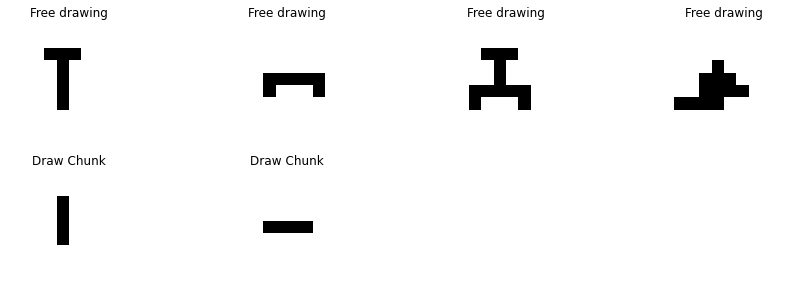


Subject  696


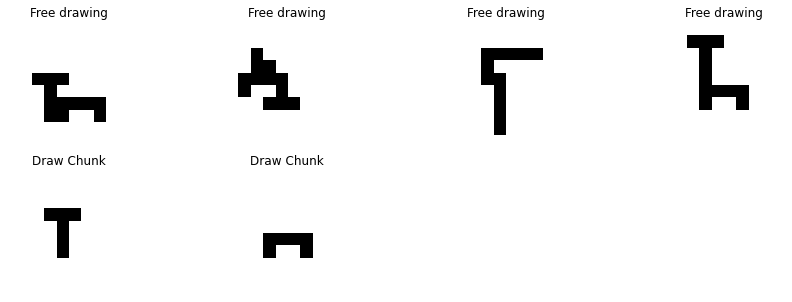


Subject  727


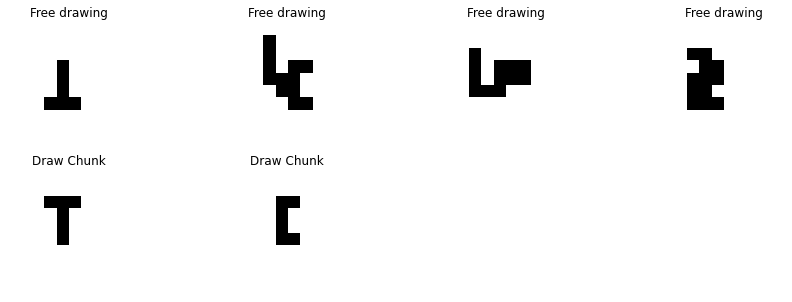


Subject  728


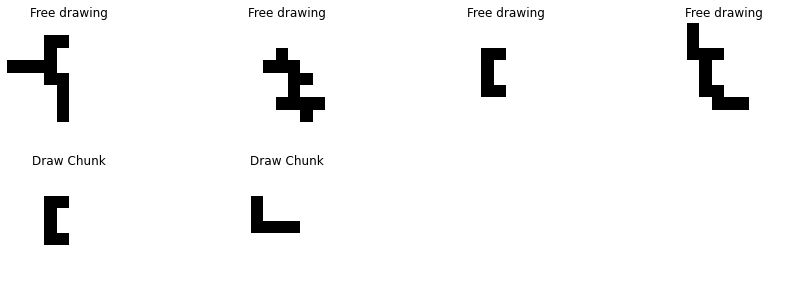


Subject  730


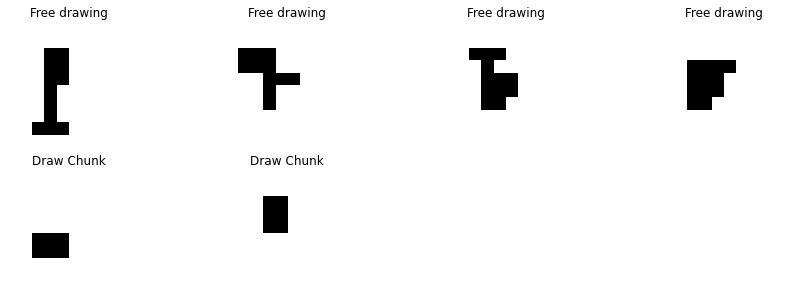


Subject  732


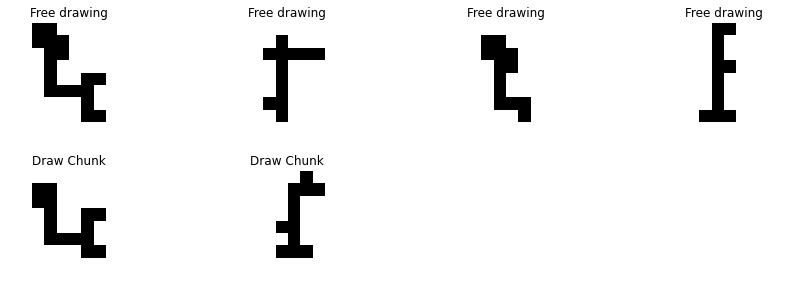


Subject  733


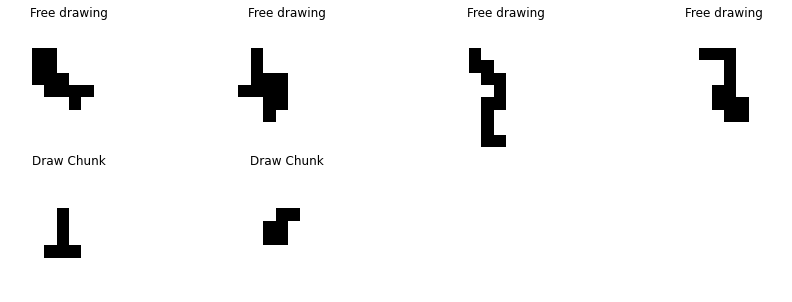


Subject  737


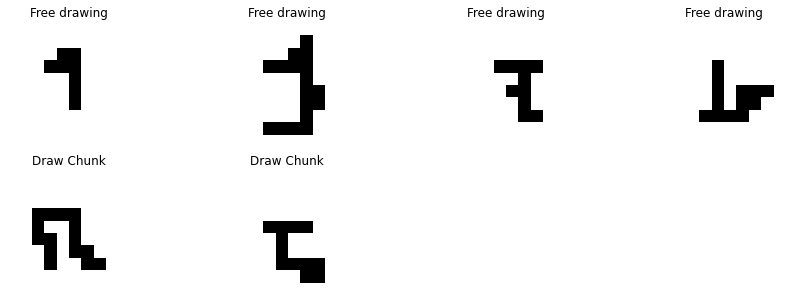


Subject  738


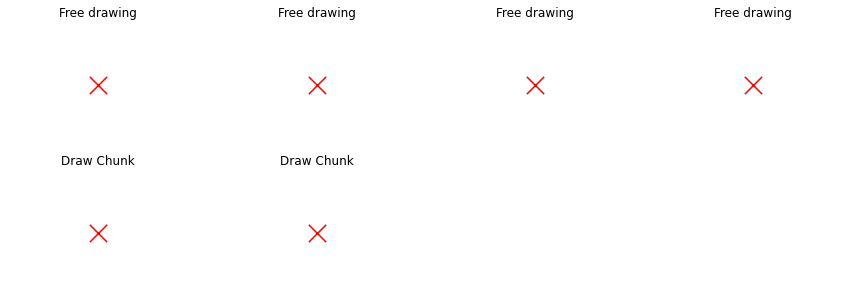


Subject  741


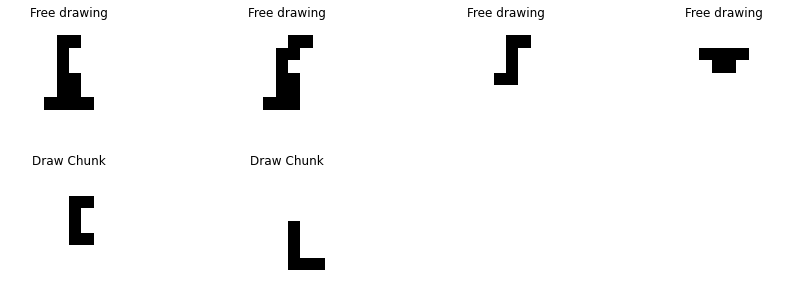


Subject  742


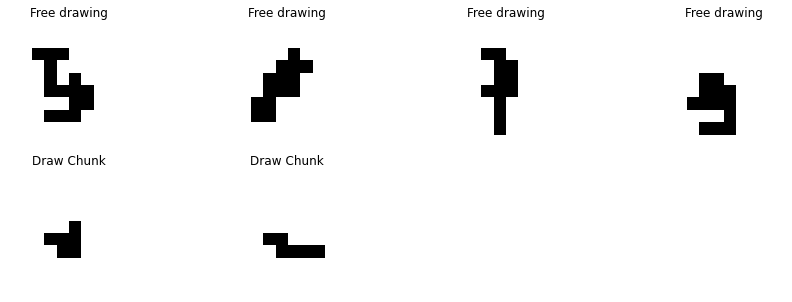


Subject  743


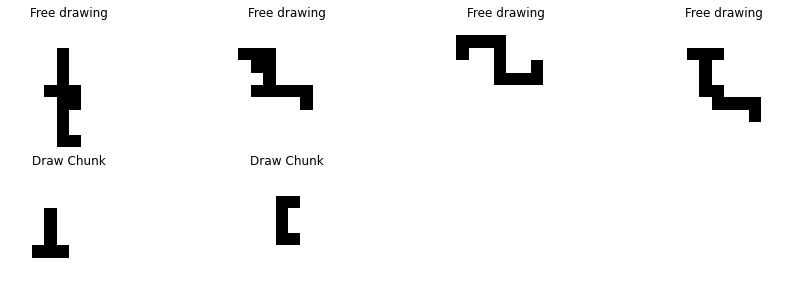


Subject  744


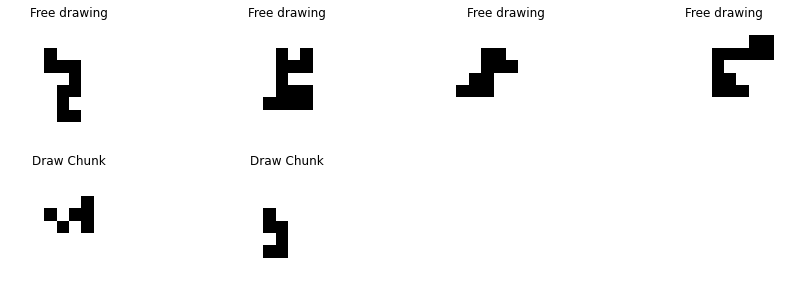


Subject  748


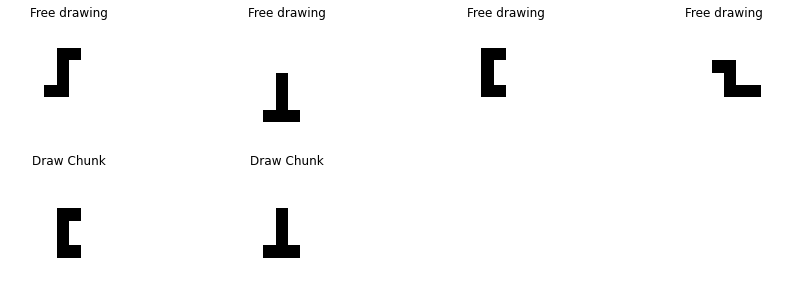


Subject  749


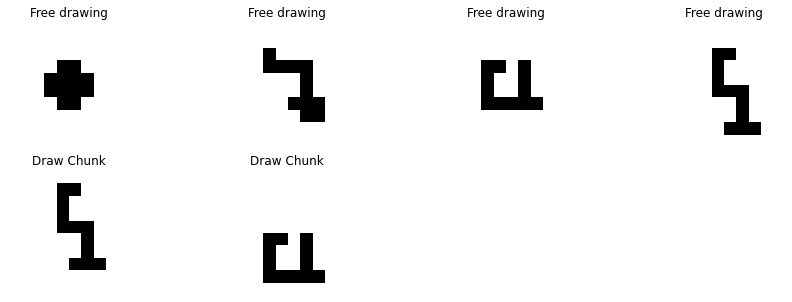


Subject  752


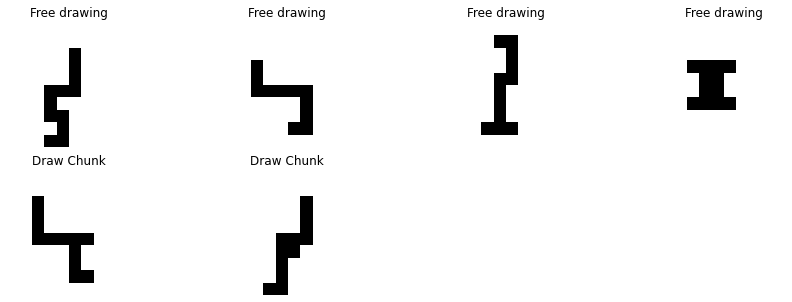


Subject  753


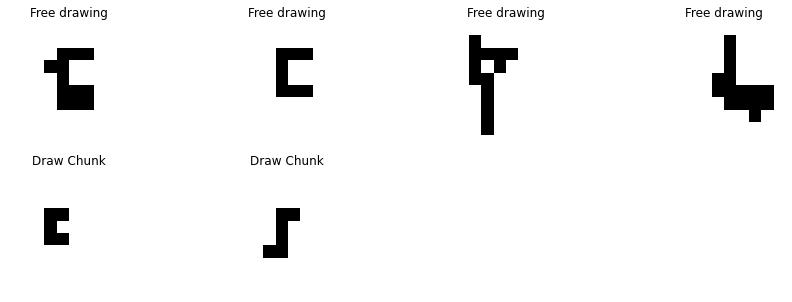


Subject  756


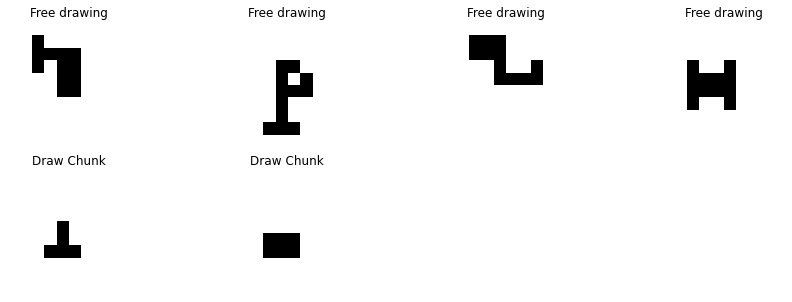


Subject  758


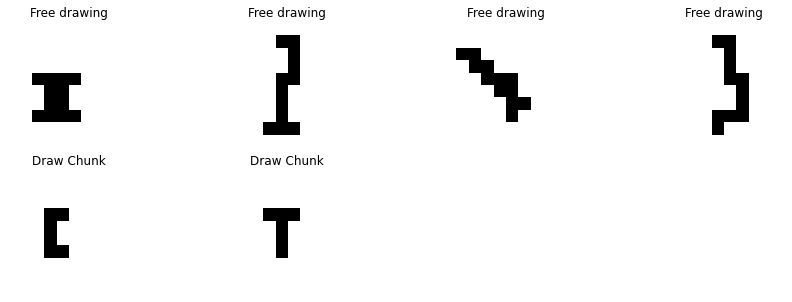


Subject  759


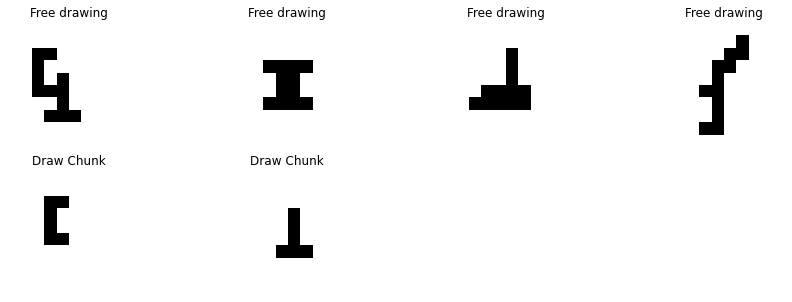


Subject  762


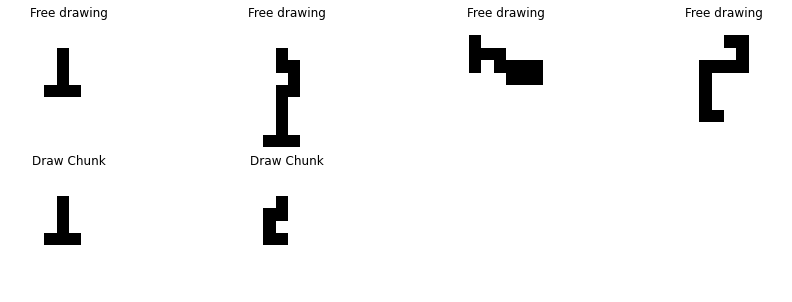


Subject  763


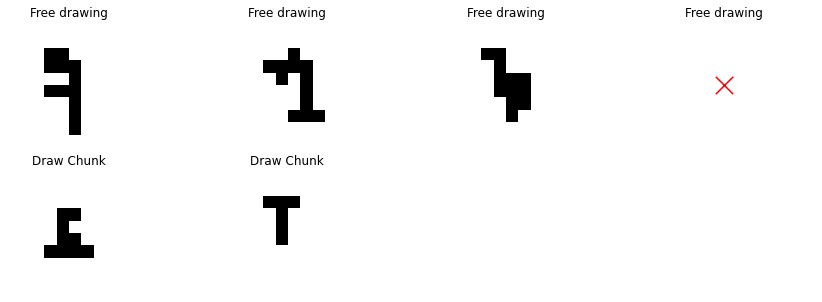


Subject  764


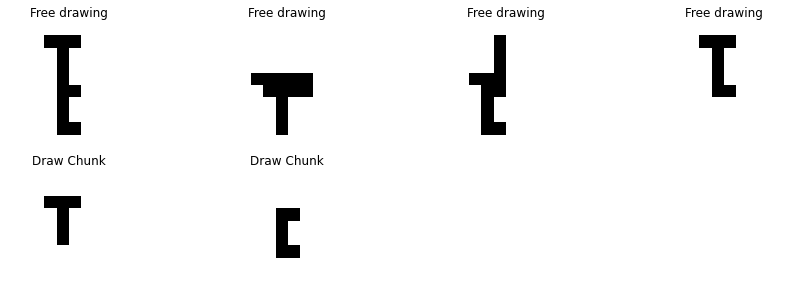


Subject  769


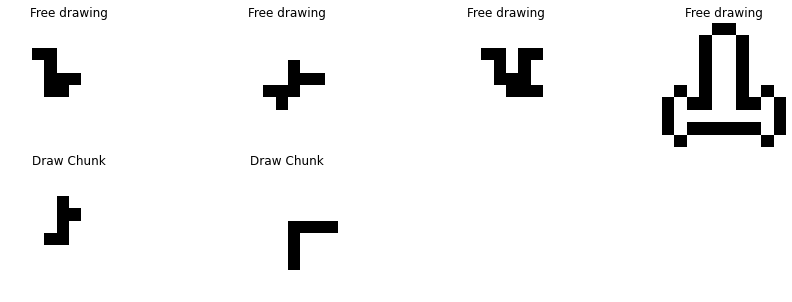


Subject  770


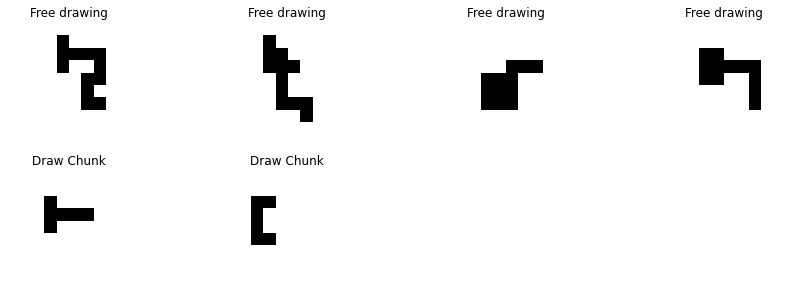


Subject  771


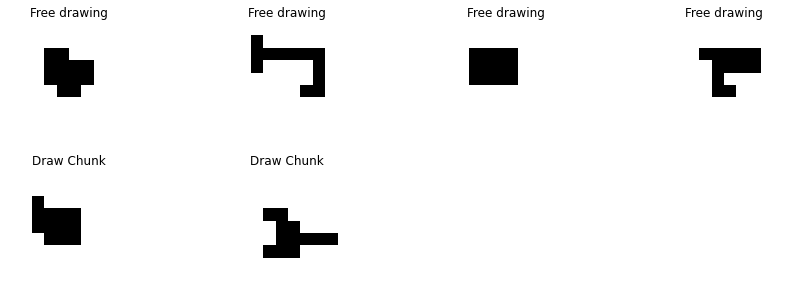


Subject  772


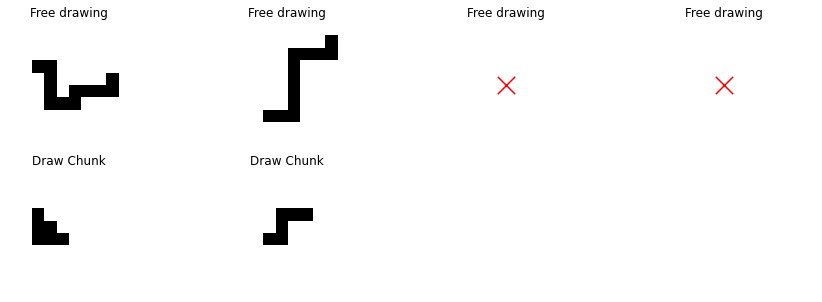


Subject  774


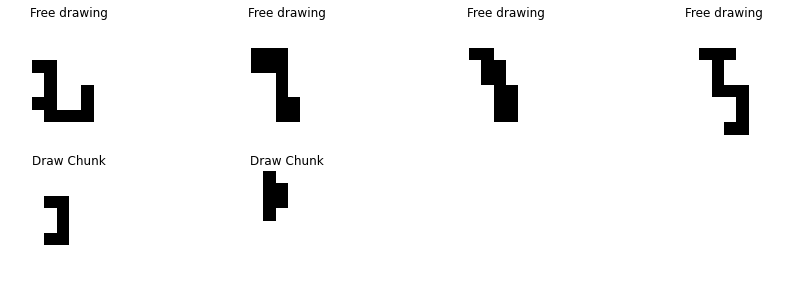


Subject  775


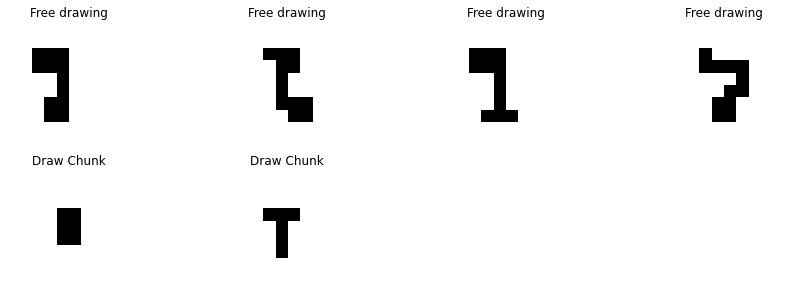


Subject  776


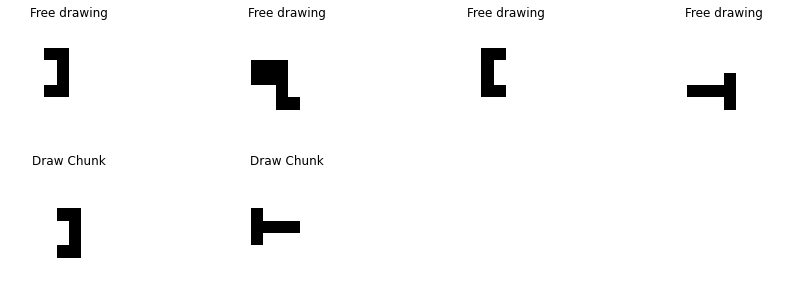


Subject  777


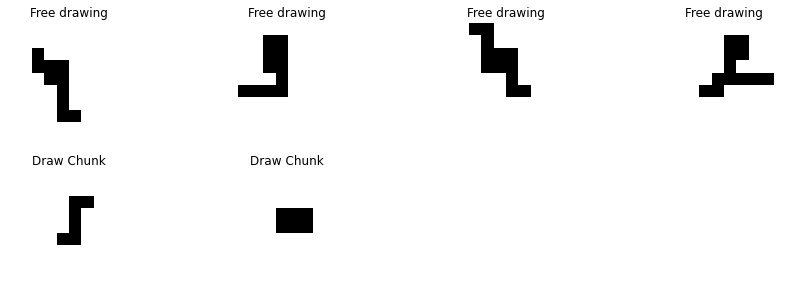


Subject  778


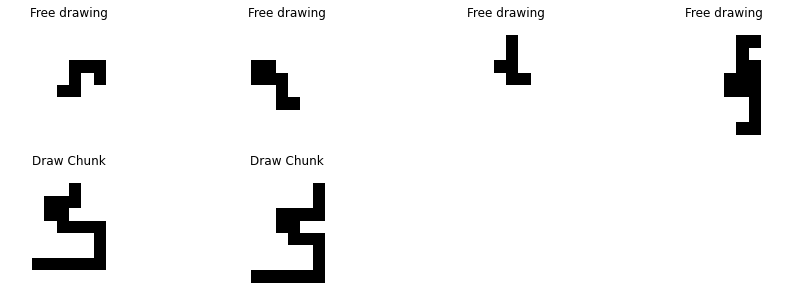


Subject  785


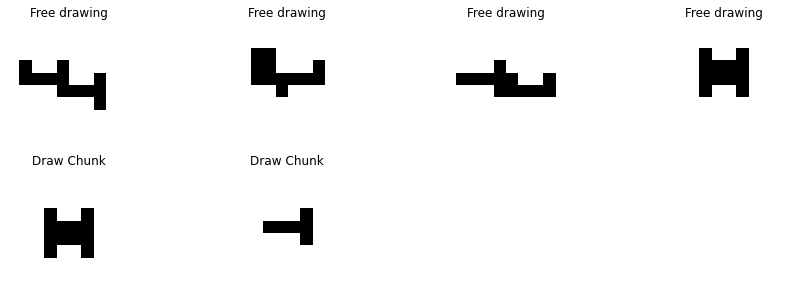


Subject  788


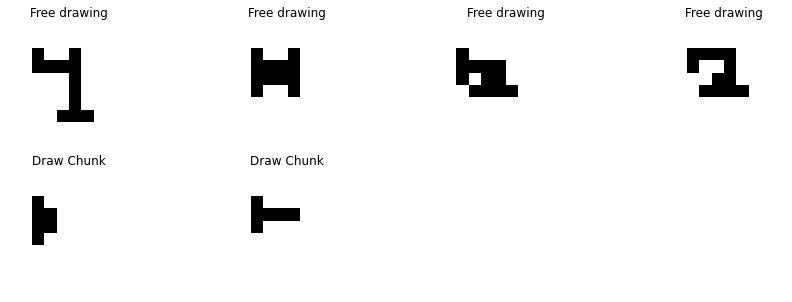


Subject  789


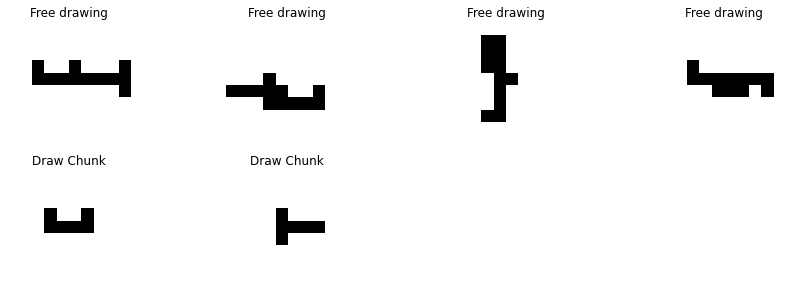


Subject  790


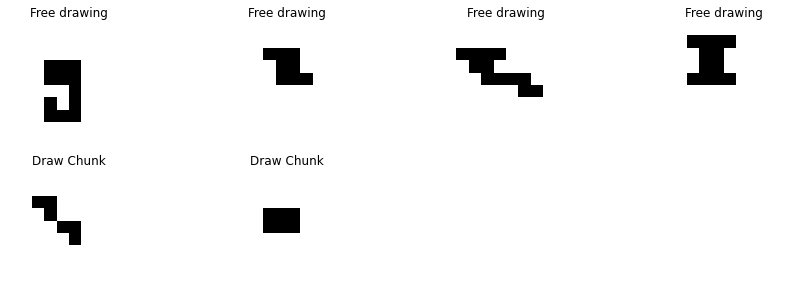


Subject  791


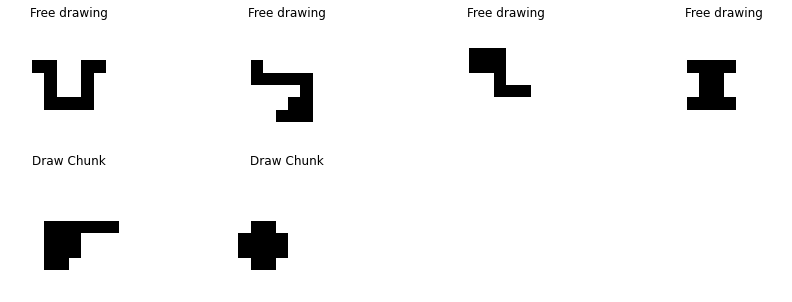


Subject  793


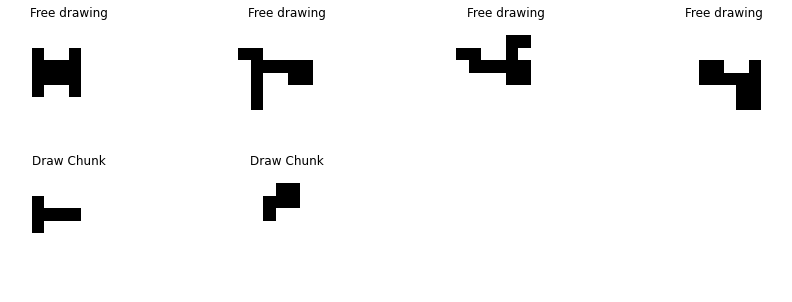


Subject  795


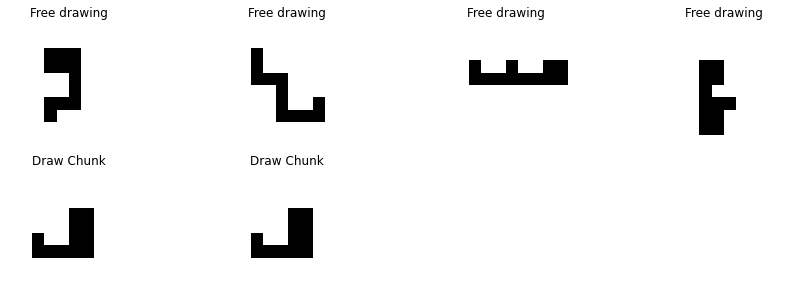


Subject  796


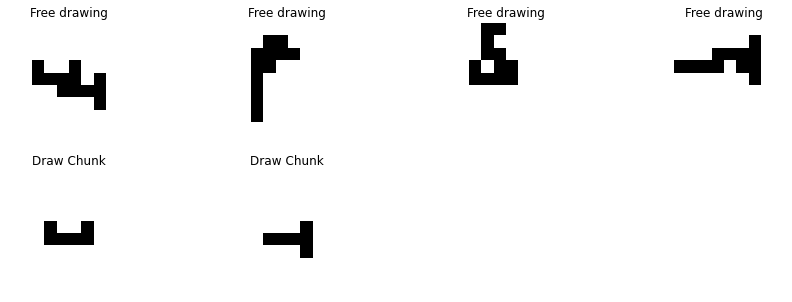


Subject  797


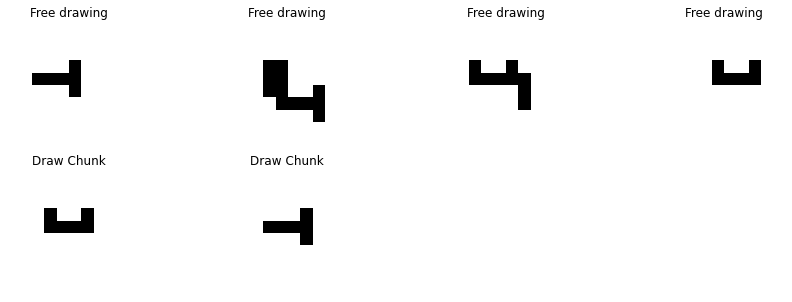


Subject  798


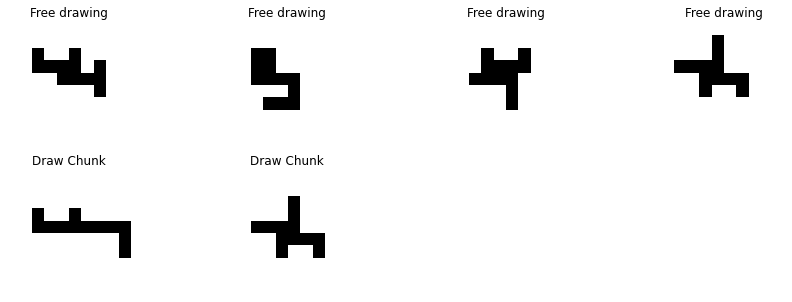

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]

# ids = [225,227,262,265] # this is pilot
# ids = [530,531,532,533,535] # stim set 0, prolific only
# ids = [531]
# ids = [530,531,532,533,535,548] # stim set 0, all subs
# ids = [554,555,556,557,558] # stim set 0, prolific only

grids = [0,1,2,3,4,5]

n_grid_reduced = 10

cols = 4
rows = 2

Titles_draw = ["Free drawing","Free drawing","Free drawing","Free drawing","Draw Chunk","Draw Chunk"]

for session_id in ids:
    print("\nSubject ", session_id)
    trials = drawing_action_df[drawing_action_df['session_id'] == session_id]
    # print(trials)

    grids_draw    = trials["grid"].to_numpy()
    x_draw        = trials["x"].to_numpy()
    y_draw        = trials["y"].to_numpy()
    selected_draw = trials["selected"].to_numpy()

    # print(grids_draw)

    fig = plt.figure()

    for grid_idx in grids: # go through the different grids on the screen
      fig.add_subplot(rows, cols, grid_idx+1)

      BB = np.zeros((n_grid_reduced,n_grid_reduced)) # initialise empty grid
      idx_draw = np.where(grids_draw==grid_idx)[0] # where did we draw on that grid
      # print(idx_draw)
      if idx_draw.size != 0: # if subject drew on that grid
        for idx_pixel in idx_draw: # go through every drawing
          BB[y_draw[idx_pixel],x_draw[idx_pixel]] = selected_draw[idx_pixel]
          plt.imshow(BB, cmap='Greys')
      else:
        plt.scatter(0, 0, s=300, c='red', marker='x')
        # print(BB)

      plt.axis('off')
      plt.title(Titles_draw[grid_idx])

    plt.show()
